In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from helper import *
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate, Flatten, Dropout


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


In [4]:
def load_images(image_dir, mask_dir,margin=0.4):
    images, masks = [], []

    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.jpg')])

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load image and mask
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Convert to grayscale for face detection
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        if len(faces) > 0:
            # Use the first detected face
            (x, y, w, h) = faces[0]

            margin_x = int(w * margin)  # margin for width
            margin_y = int(h * margin)  # margin for height

            # Adjust the coordinates to include the margin
            x = max(x - margin_x, 0)
            y = max(y - margin_y, 0)
            w = min(w + 2 * margin_x, image.shape[1] - x)
            h = min(h + 2 * margin_y, image.shape[0] - y)

            # Crop image and mask using the same coordinates
            cropped_img = image[y:y+h, x:x+w]
            cropped_mask = mask[y:y+h, x:x+w]
        else:
            # If no face detected, use full image and mask
            cropped_img = image
            cropped_mask = mask

        # Resize to match expected input size
        resized_img = cv2.resize(cropped_img, (128, 128))
        gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
        binary_mask = np.where(cropped_mask > 0, 1, 0).astype(np.uint8)
        resized_mask = cv2.resize(binary_mask, (128, 128))


        images.append(gray_img)
        masks.append(resized_mask)

    return images, masks


# def load_images(image_dir, mask_dir):
#     images, masks = [], []
#     for file in os.listdir(image_dir):
#         if file.endswith('.jpg'):
#             image = cv2.imread(image_dir + file,cv2.IMREAD_GRAYSCALE)
#             image = cv2.resize(image, (128,128))
#             images.append(image)
#     for file in os.listdir(mask_dir):
#         if file.endswith('.jpg'):
#             mask = cv2.imread(mask_dir + file, cv2.IMREAD_GRAYSCALE)
#             binary_mask = np.where(mask > 0, 1, mask)
#             # binary_mask *= 255
#             binary_mask = cv2.resize(binary_mask, (128, 128))
#             masks.append(binary_mask)
#     return images, masks
#     # for file in os.listdir(image_dir):
#     #     if file.endswith('.jpg'):
#     #         image = cv2.imread(image_dir + file,cv2.IMREAD_GRAYSCALE)
#     #         image = cv2.resize(image, (128,128))
#     #         images.append(image)
#     # for file in os.listdir(mask_dir):
#     #     if file.endswith('.png'):
#     #         mask = cv2.imread(mask_dir + file,cv2.IMREAD_GRAYSCALE)
#     #         mask = cv2.resize(mask, (128, 128))
#     #         masks.append(mask)
#     # return images, masks

In [5]:
images, masks = load_images("data_ours/images_temp/", "data_ours/masks_temp/")
# images, masks = load_images("data/images/","data/masks/")
print(len(images))
print(len(masks))
print(np.unique(masks[0]))

98
98
[0 1]


In [6]:
images_augmented, masks_augmented = augmentData(images, masks)
print(len(images_augmented))
print(len(masks_augmented))

1176
1176


In [7]:
def plot_images(images, masks,num):
    plt.figure(figsize=(18, 9))
    for i in range(num):
        idx = random.randint(0, len(images))
        img = images[idx]
        mask = masks[idx]
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f'Real Image, index = {idx}')
        plt.axis('off')
        plt.subplot(2, 4, i + num + 1)
        plt.imshow(mask)
        plt.title(f'Segmented Image, index = {idx}')
        plt.axis('off')
        del img, mask


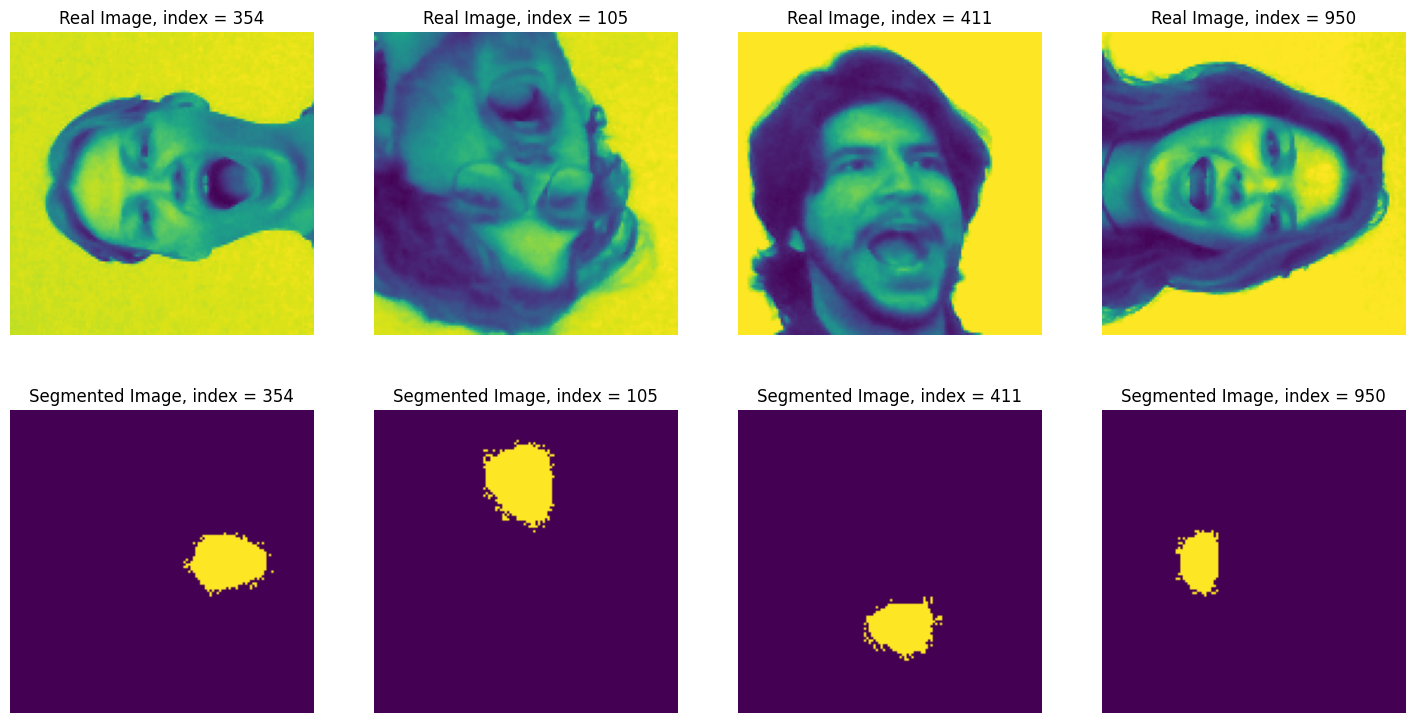

In [8]:
plot_images(images_augmented, masks_augmented,4)
# plot_images(images,masks,4)

In [9]:
def to_tensor(image_list, mask_list):
    tensor_images = tf.convert_to_tensor(tf.cast(np.array(image_list),  dtype = tf.float32))/255
    tensor_masks = tf.convert_to_tensor(tf.cast(np.array(mask_list), dtype= tf.float32))/255
    return tensor_images, tensor_masks

In [10]:
# images, masks = to_tensor(images, masks)
# images, masks = to_tensor(images_augmented, masks_augmented)
images = np.array(images_augmented)
masks = np.array(masks_augmented)

In [11]:
#splitting the images and masks into train, test and split
# train_split = tf.cast(tf.round(len(images)*0.6) - 1, dtype = tf.int32)
# test_val_split = tf.cast(tf.round(len(images)*0.2), dtype = tf.int32)

# Set random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

indices = np.arange(len(images))
np.random.shuffle(indices)

images = images[indices]
masks = masks[indices]

total_size = len(images)
train_split = int(total_size * 0.6)
test_val_split = int(total_size * 0.2)

images_train = images[:train_split]
masks_train = masks[:train_split]

images_val = images[train_split:train_split + test_val_split]
masks_val = masks[train_split:train_split + test_val_split]

images_test = images[train_split + test_val_split:]
masks_test = masks[train_split + test_val_split:]

del images, masks

print(f'The length of images and masks for training is {len(images_train)} and {len(masks_train)} respectively')
print(f'The length of images and masks for validation is {len(images_val)} and {len(masks_val)} respectively')
print(f'The length of images and masks for testing is {len(images_test)} and {len(masks_test)} respectively')

The length of images and masks for training is 705 and 705 respectively
The length of images and masks for validation is 235 and 235 respectively
The length of images and masks for testing is 236 and 236 respectively


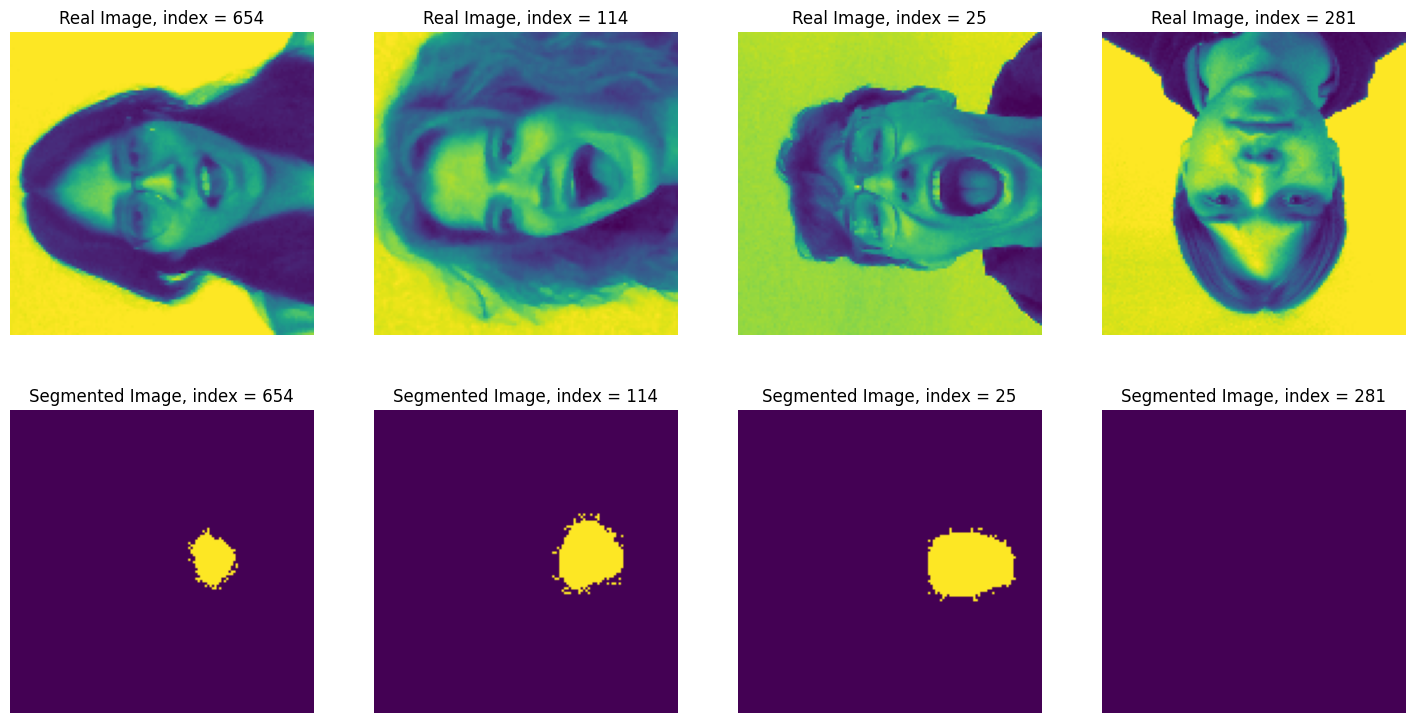

In [54]:
plot_images(images_train, masks_train,4)

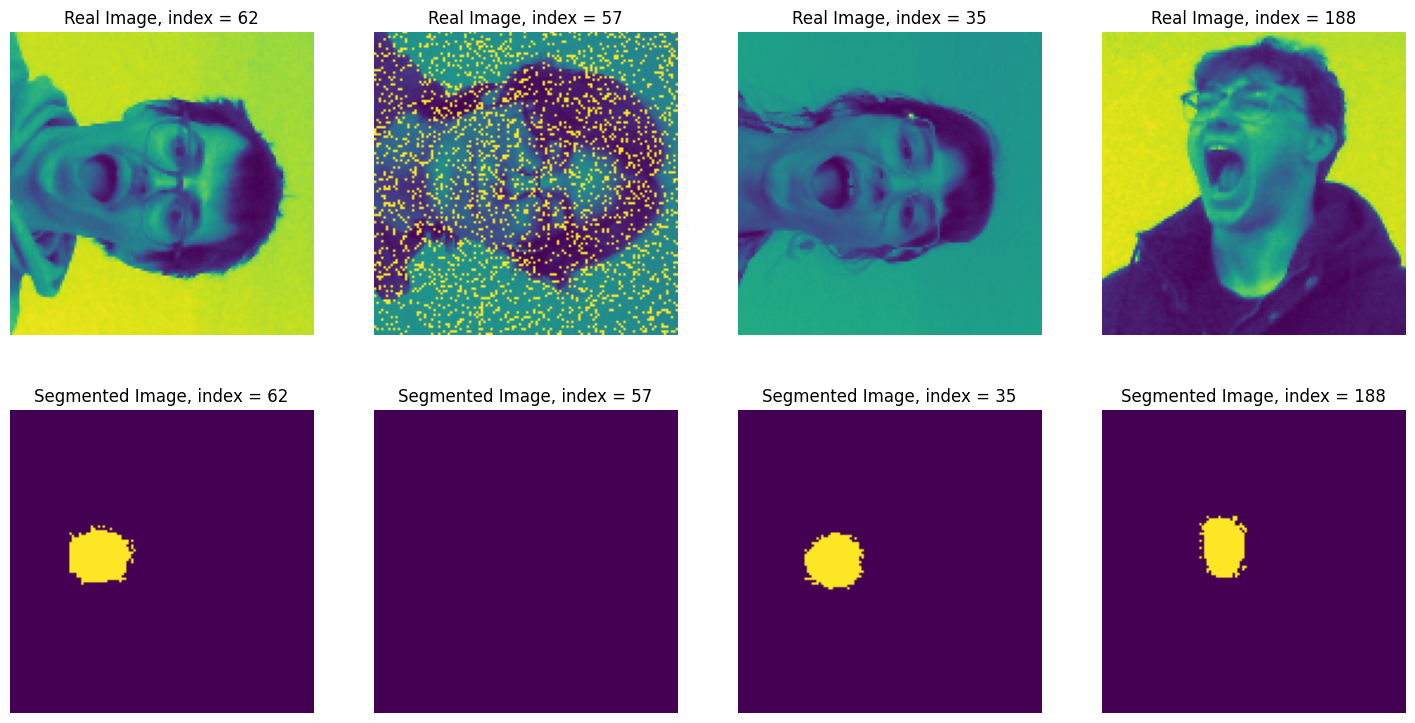

In [55]:
plot_images(images_val, masks_val,4)

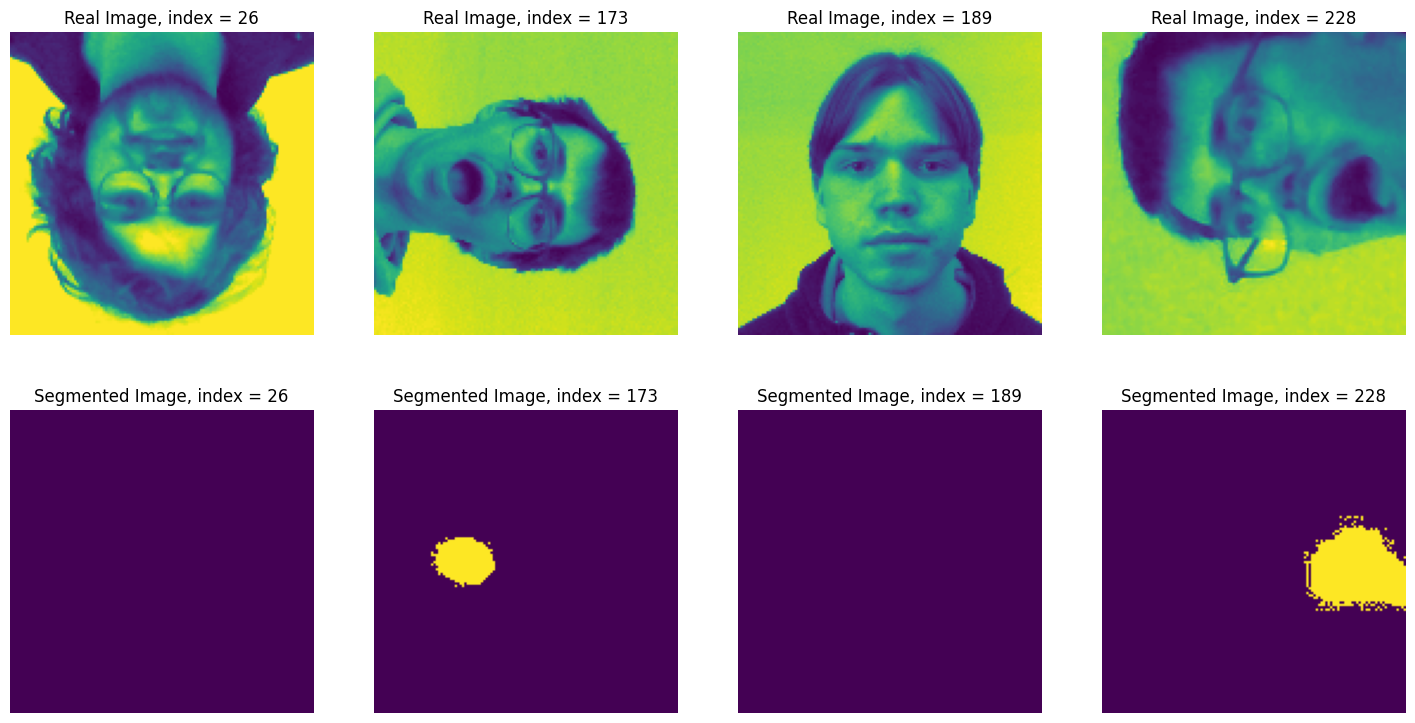

In [56]:
plot_images(images_test, masks_test,4)

In [12]:
#Converting the list of tensors into batches to efficiently train the model, computation-wise
batch_size = 5

train_data = tf.data.Dataset.from_tensor_slices((images_train, masks_train))
train_data = train_data.batch(batch_size)

val_data = tf.data.Dataset.from_tensor_slices((images_val, masks_val))
val_data = val_data.batch(batch_size)

test_data = tf.data.Dataset.from_tensor_slices((images_test, masks_test))
test_data = test_data.batch(batch_size)

In [13]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [59]:
unet = unet()
unet.compile(loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy', dice_coefficient])
unet.summary()

Model: "Unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 512) │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 16, 16,    │  2,097,664 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 25,808,193 (98.45 MB)

 Trainable params: 25,808,193 (98.45 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [61]:
unet_history = unet.fit(train_data,validation_data=[val_data],
                        epochs = 50, callbacks = [early_stopping])

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.9233 - dice_coefficient: 0.0090 - loss: 0.6821 - val_accuracy: 0.9747 - val_dice_coefficient: 6.0125e-04 - val_loss: 0.3903
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9733 - dice_coefficient: 0.0326 - loss: 0.1901 - val_accuracy: 0.9747 - val_dice_coefficient: 0.0572 - val_loss: 0.1304
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9744 - dice_coefficient: 0.0536 - loss: 0.1215 - val_accuracy: 0.9747 - val_dice_coefficient: 0.0538 - val_loss: 0.1224
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9744 - dice_coefficient: 0.0535 - loss: 0.1185 - val_accuracy: 0.9747 - val_dice_coefficient: 0.0551 - val_loss: 0.1205
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.9744 - dice_coefficient: 0.0529 - loss: 0.1154 - val_accuracy: 0.9747 - val_dice_coefficient: 0.0618 - val_loss: 0.1194
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accur

NameError: name 'unet_history' is not defined

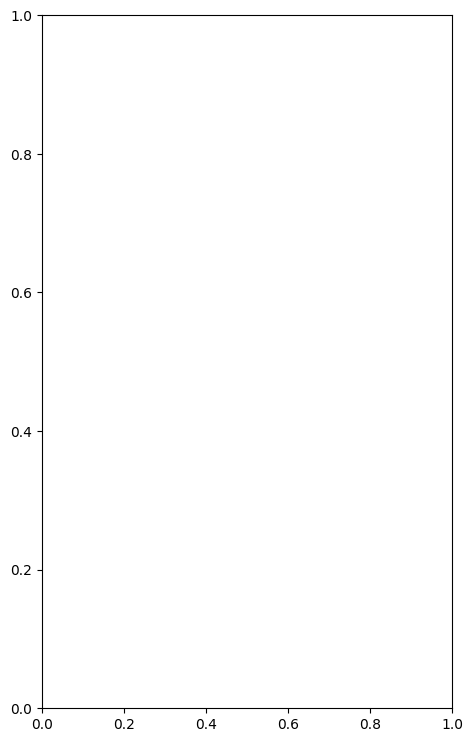

In [14]:
#Plotting the loss and accuracy during training and validation
plt.figure(figsize = (18, 9))
plt.subplot(1,3,1)
plt.plot(unet_history.history['loss'])
plt.plot(unet_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.subplot(1,3,2)
plt.plot(unet_history.history['accuracy'])
plt.plot(unet_history.history['val_accuracy'])
plt.title('Training vs Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.subplot(1,3,3)
plt.plot(unet_history.history['dice_coefficient'])
plt.plot(unet_history.history['val_dice_coefficient'])
plt.title('Training vs Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend(['Training Dice Coefficient', 'Validation Coefficient'])

In [63]:
conv_layers = [layer for layer in unet.layers if 'conv' in layer.name.lower()]
layer_outputs = [layer.output for layer in unet.layers if 'conv' in layer.name.lower()]
activation_model = Model(inputs=unet.input, outputs=layer_outputs)
test_img = images_test[125]
test_img = tf.expand_dims(test_img, axis = 0)
test_img = tf.expand_dims(test_img, axis = -1)
activations = activation_model.predict(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [15]:
def plot_feature_maps(activation, layer_name, num_maps=6):
    num_maps = min(num_maps, activation.shape[-1])  # Make sure we don't exceed available channels
    fig, axes = plt.subplots(1, num_maps, figsize=(20, 8))
    fig.suptitle(f'Layer: {layer_name}', fontsize=16)

    # If there's only one map, wrap axes in a list
    if num_maps == 1:
        axes = [axes]

    for i in range(num_maps):
        axes[i].imshow(activation[0, :, :, i], cmap='viridis')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

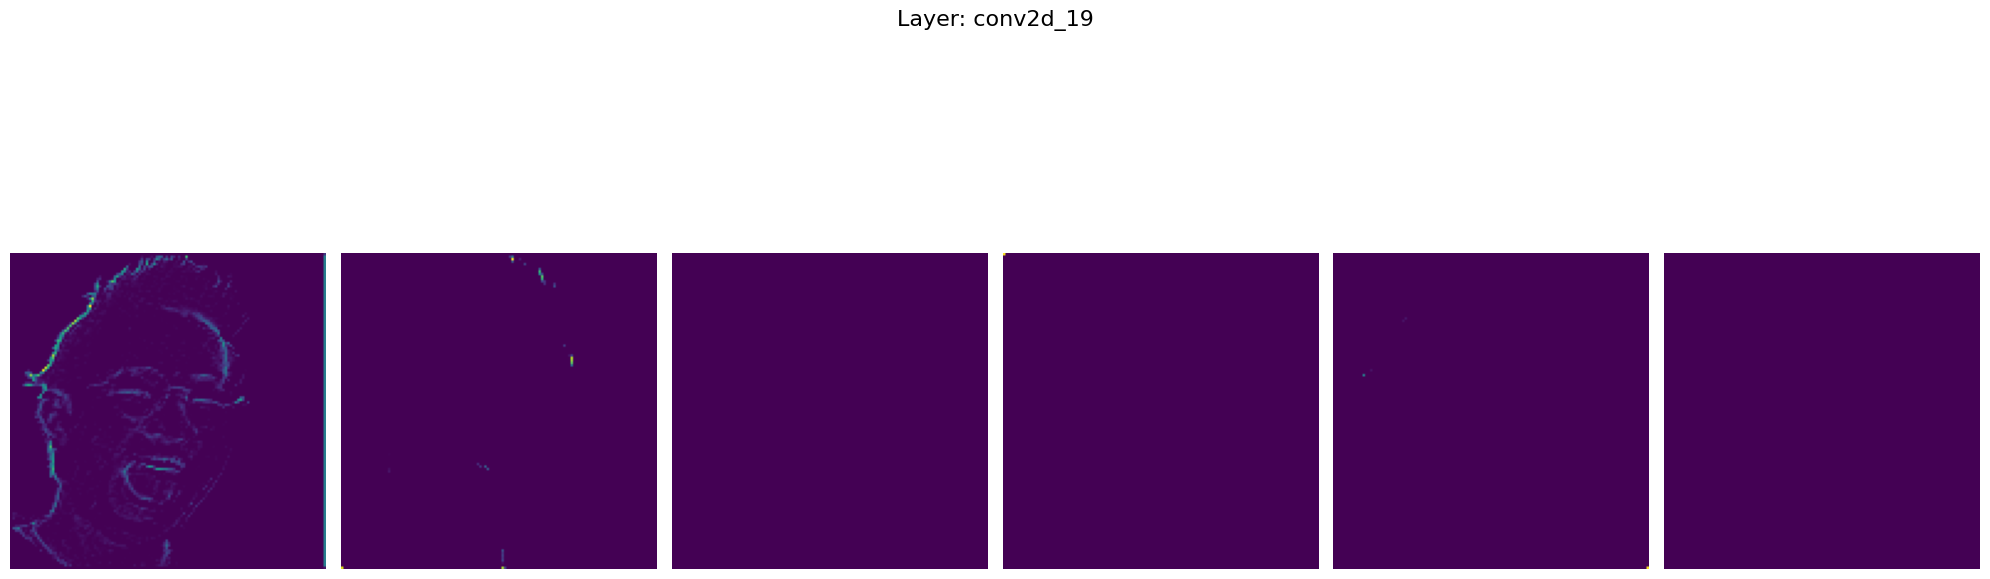

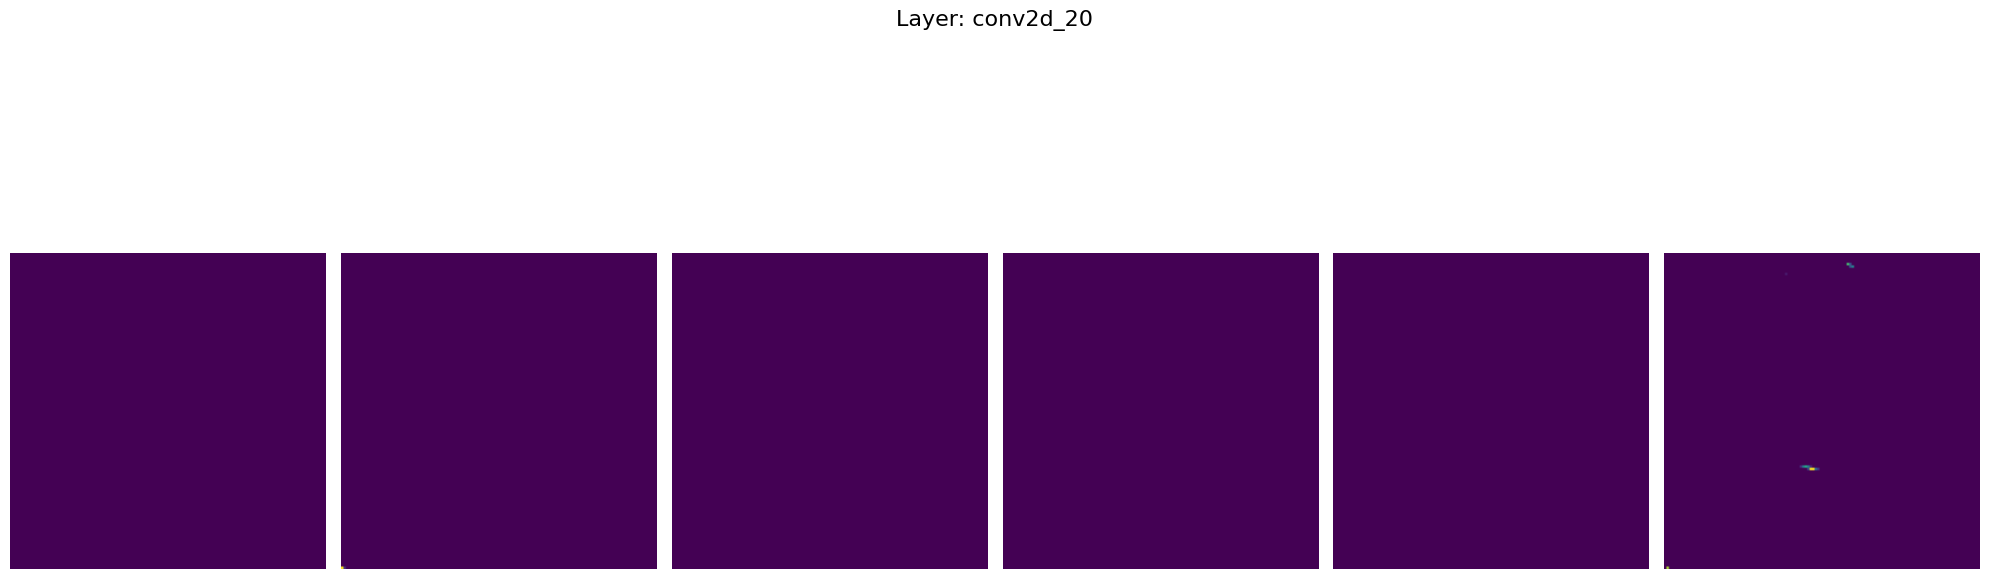

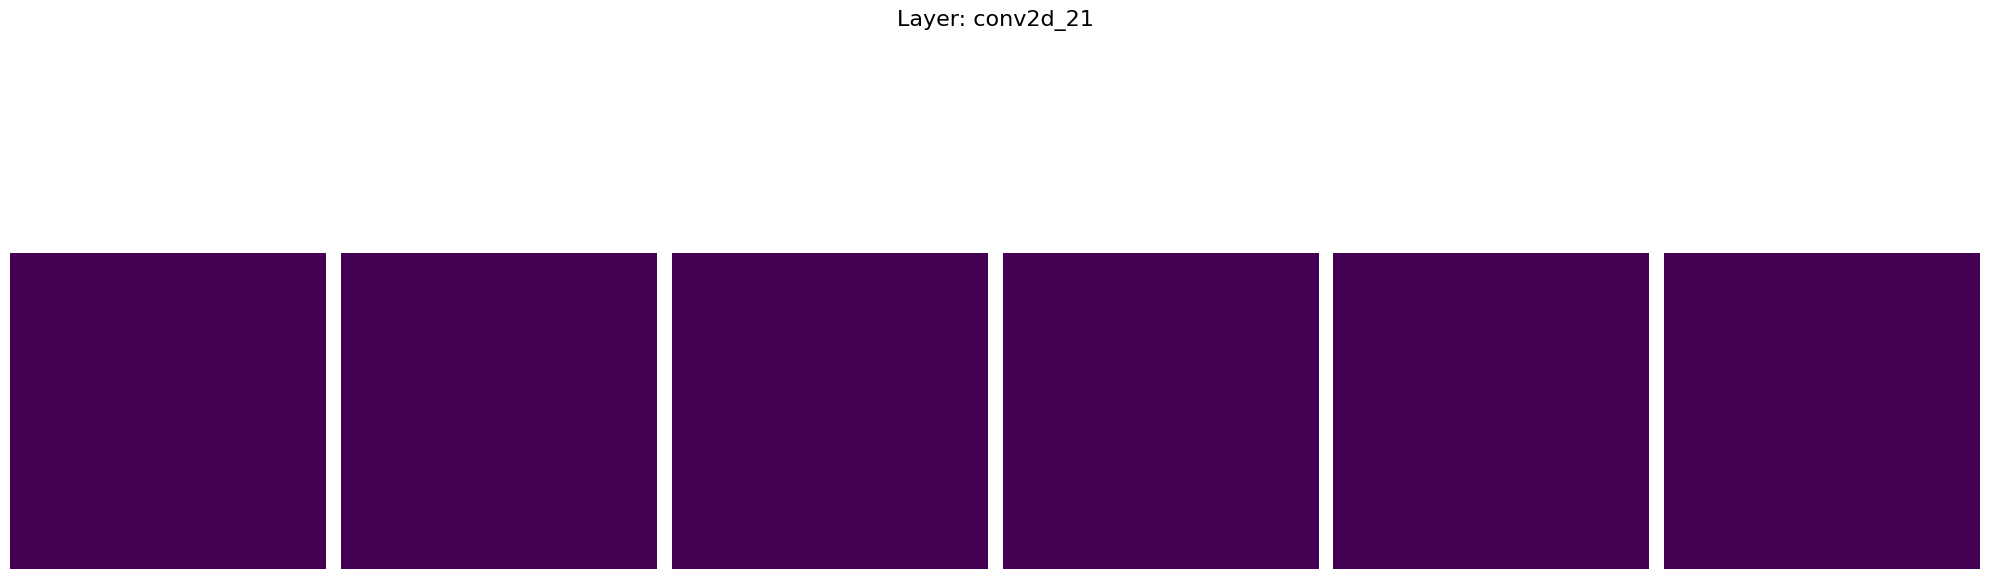

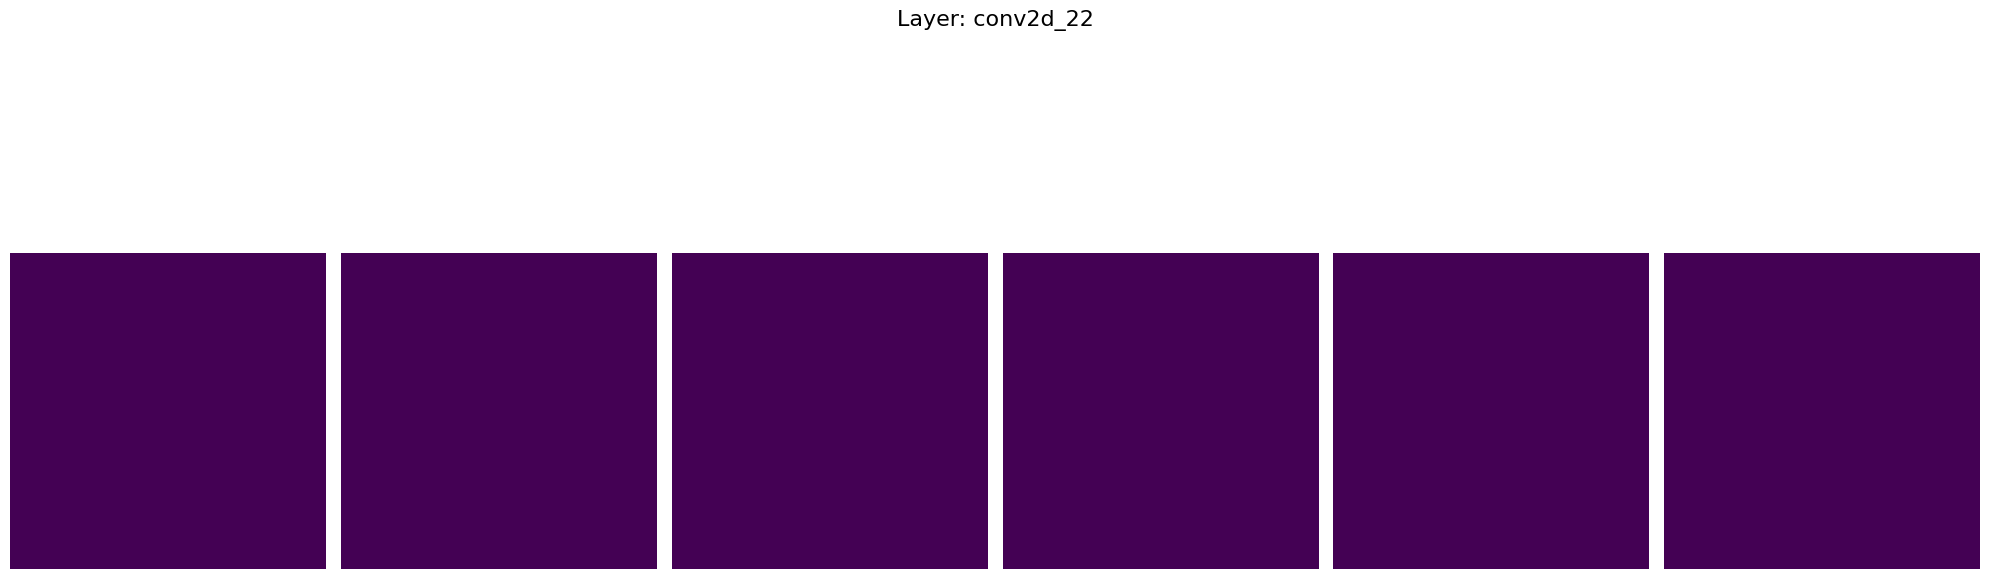

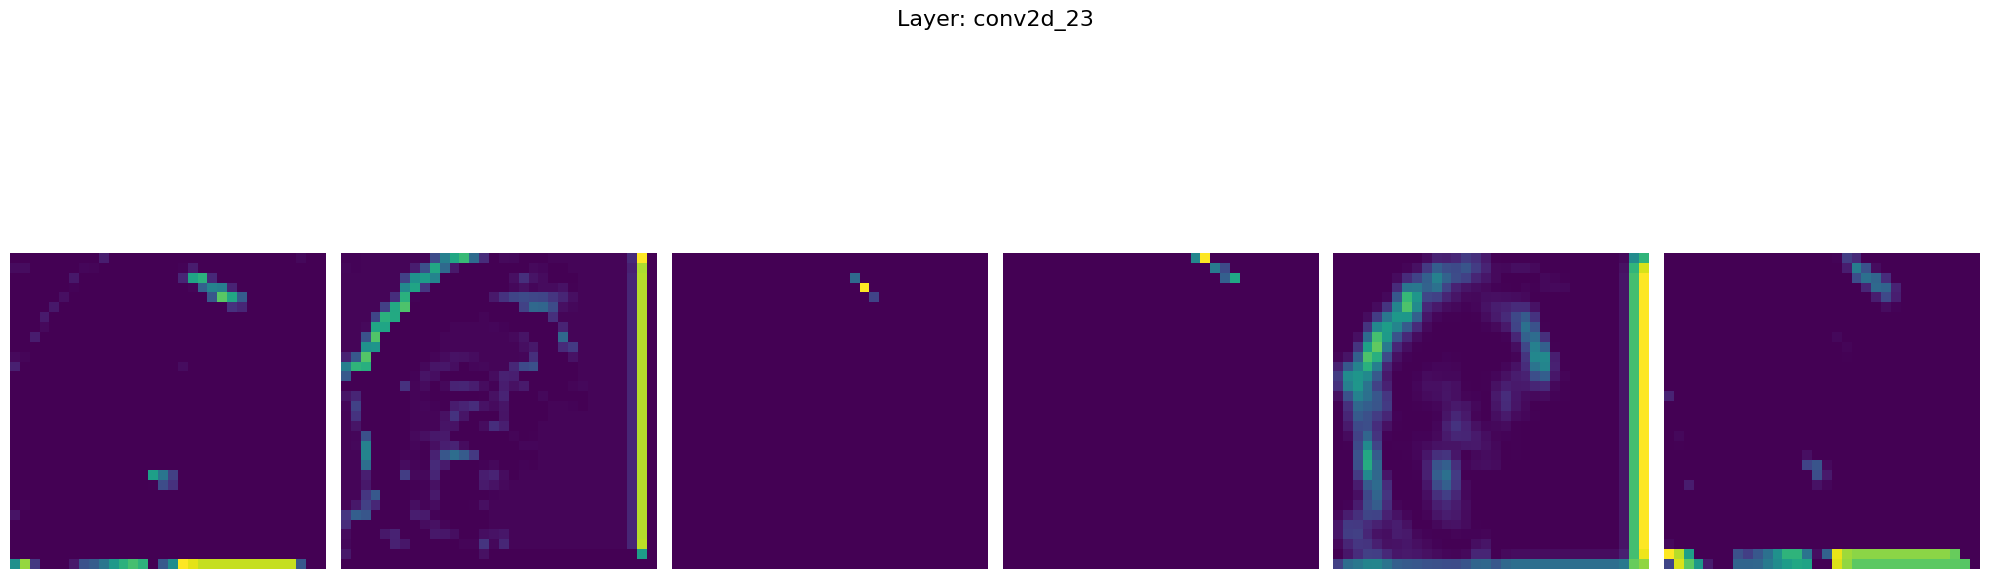

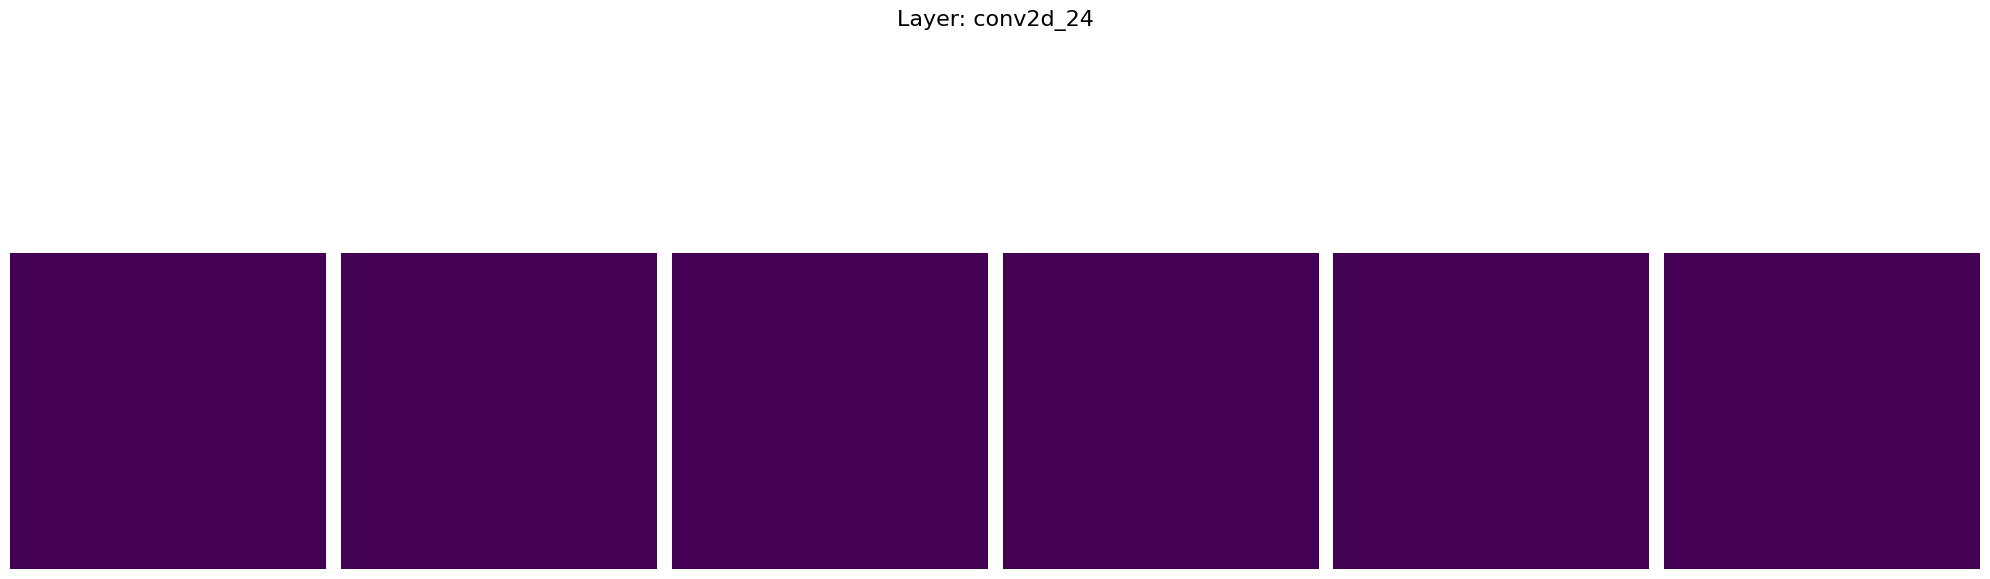

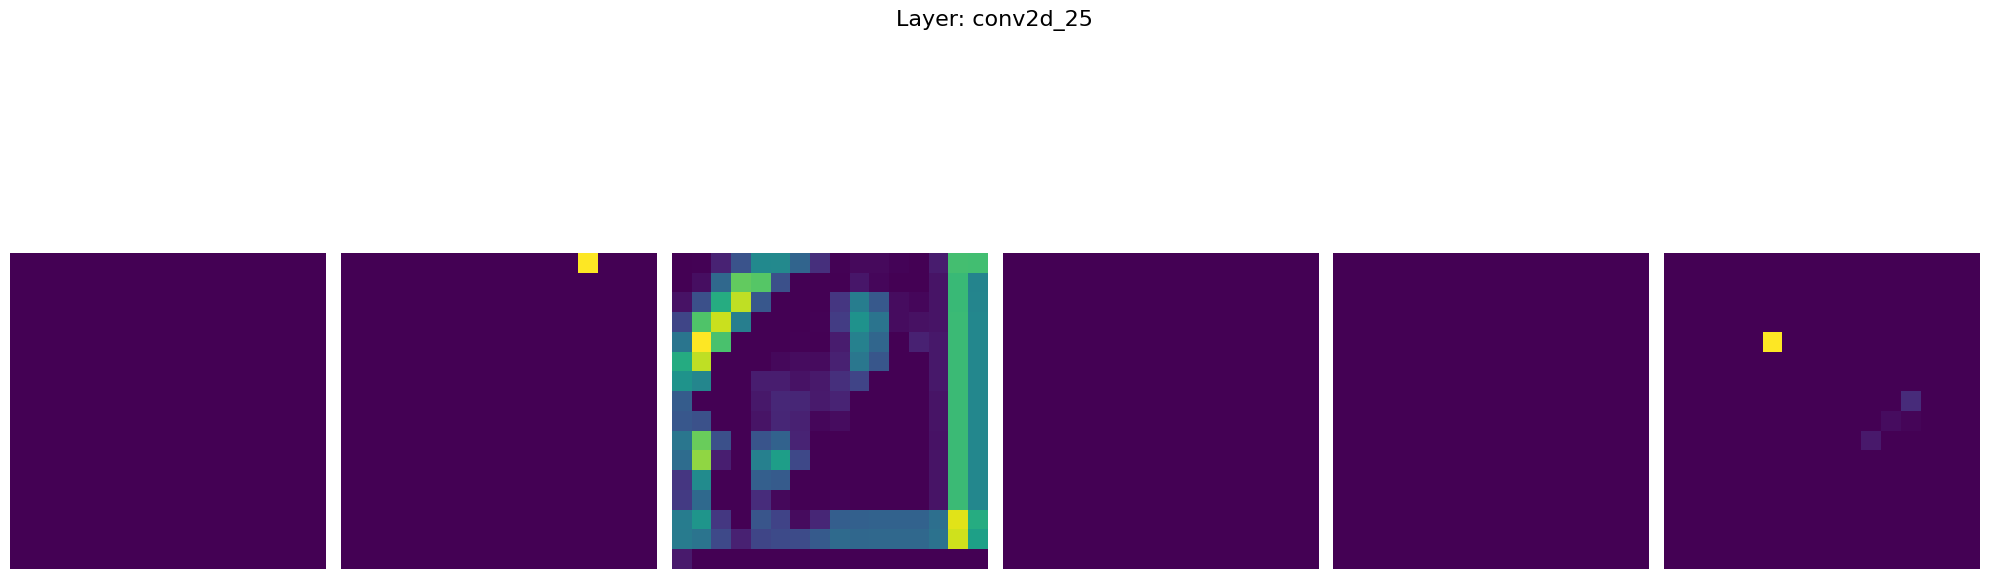

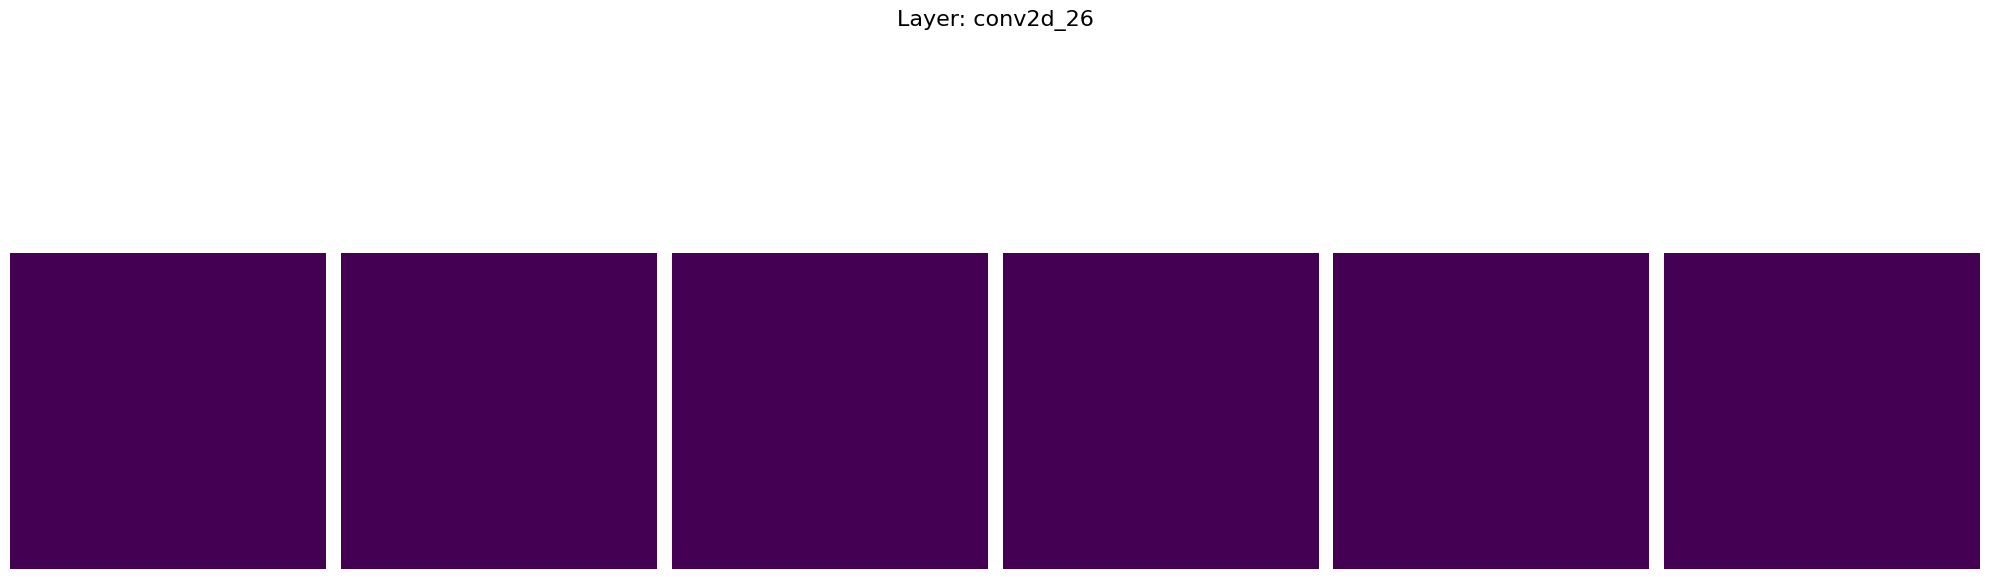

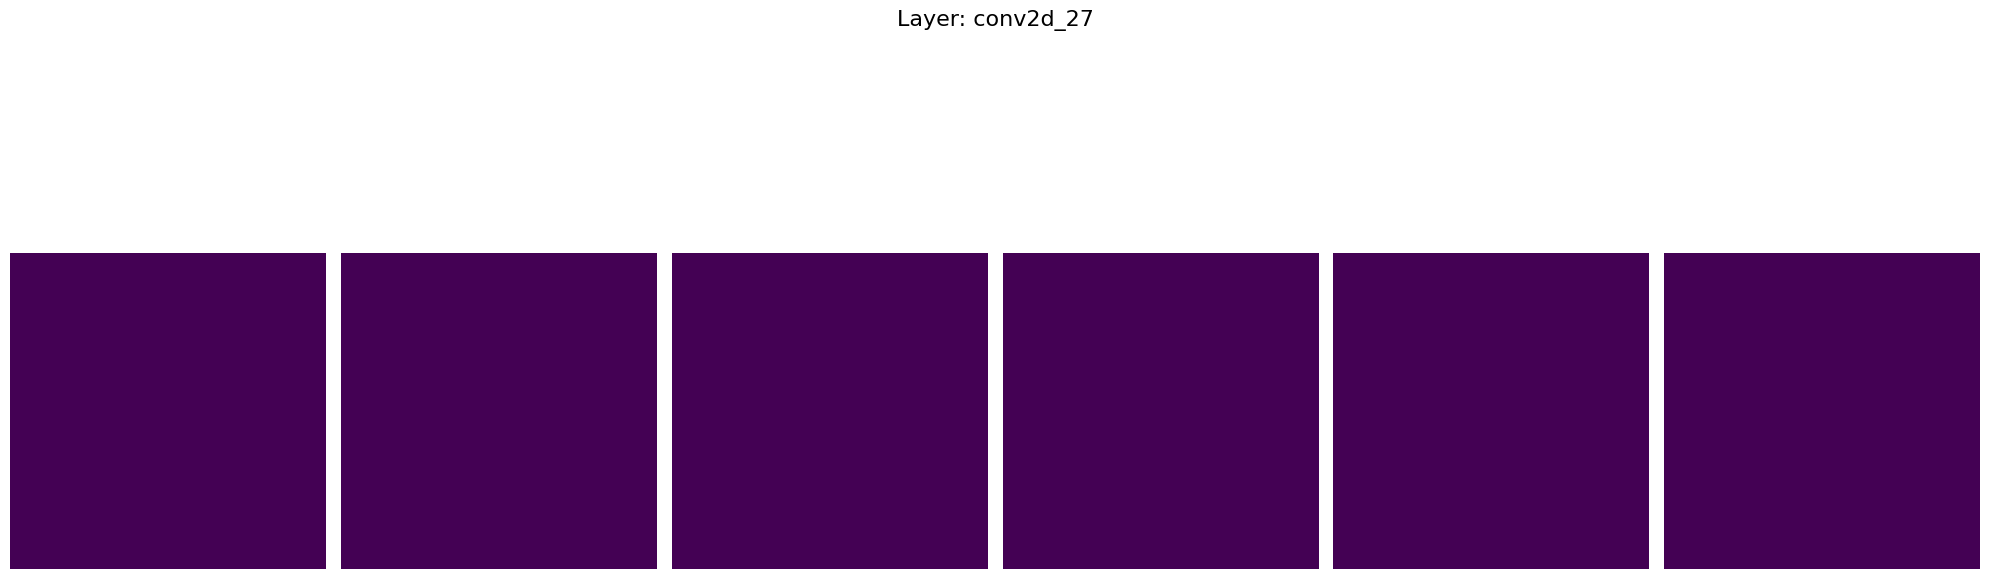

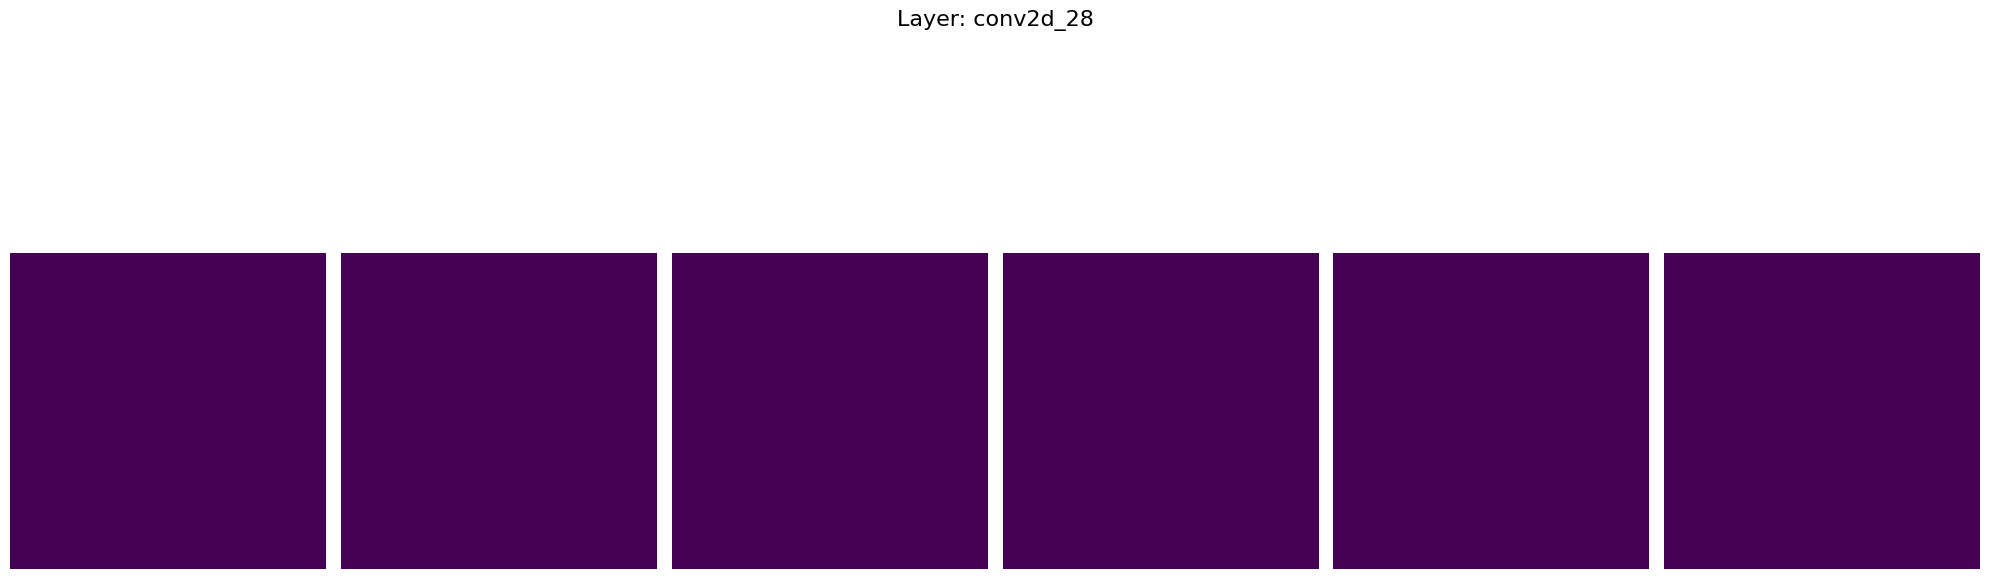

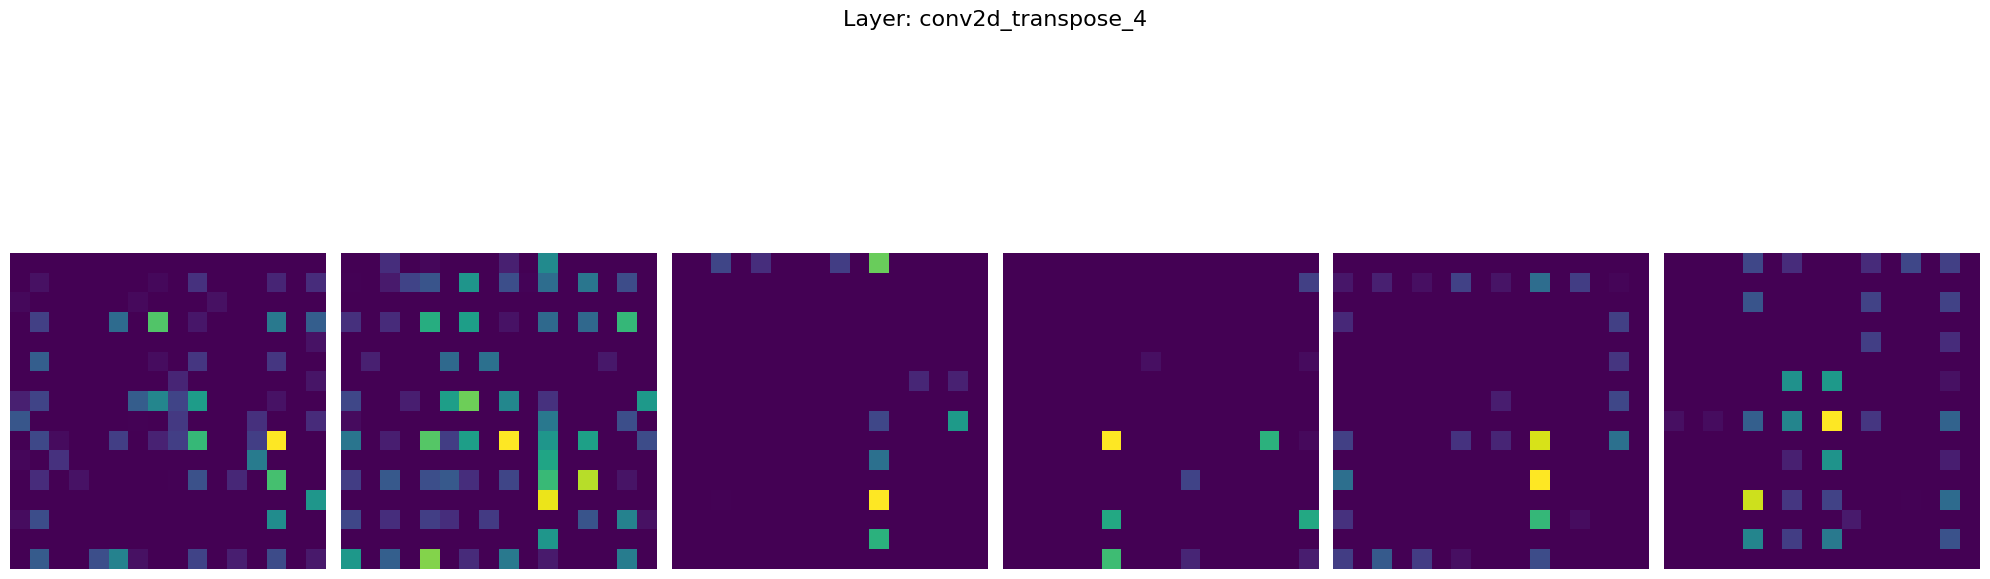

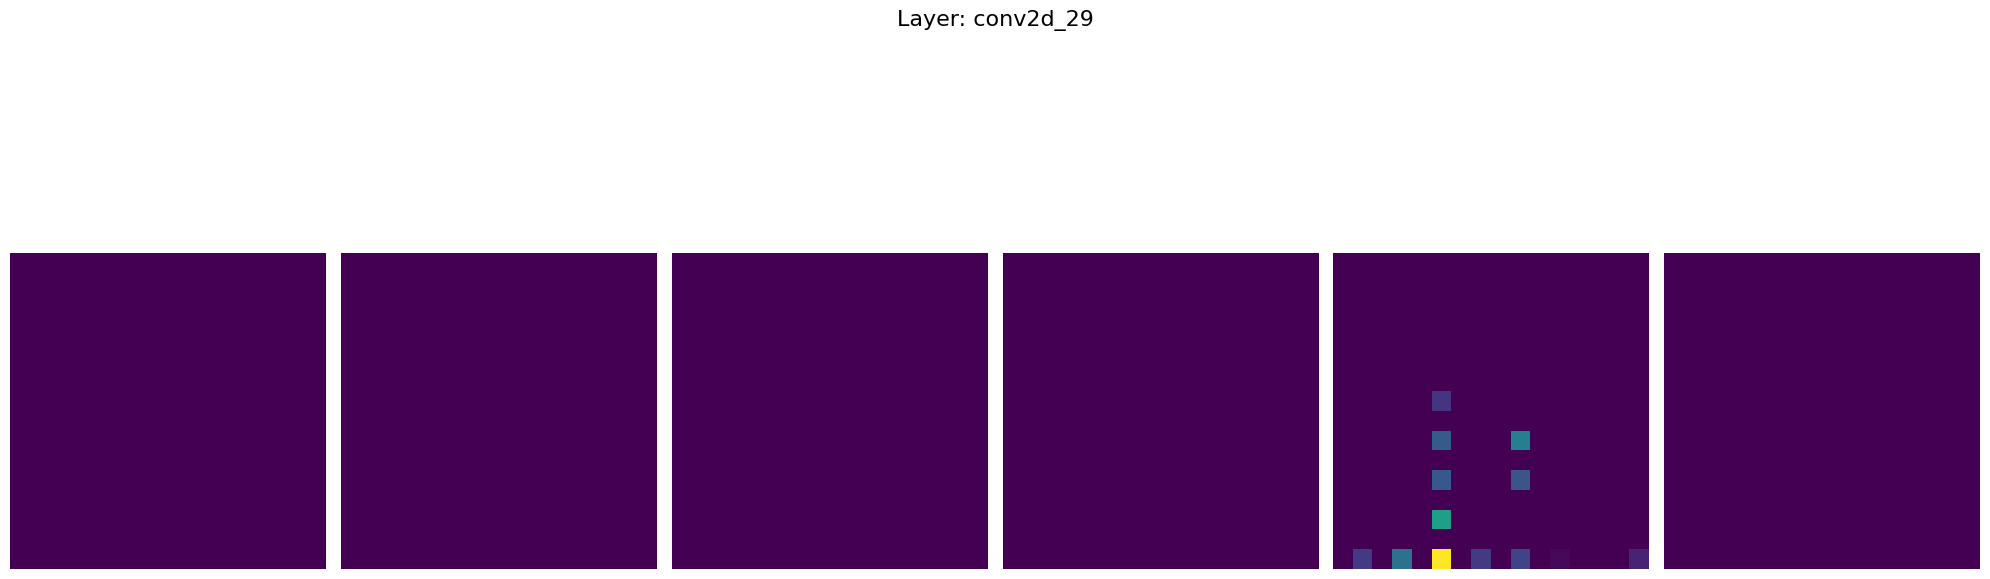

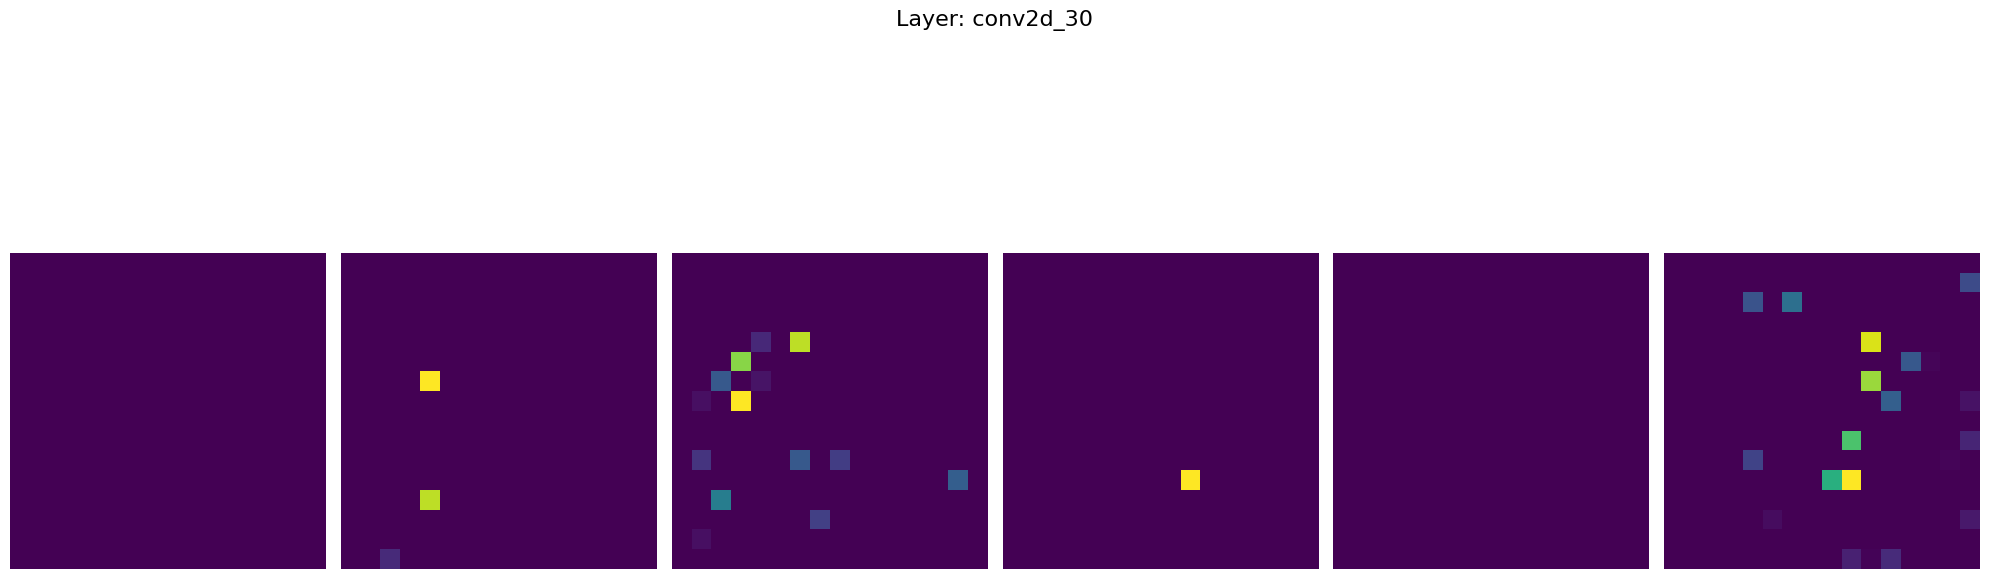

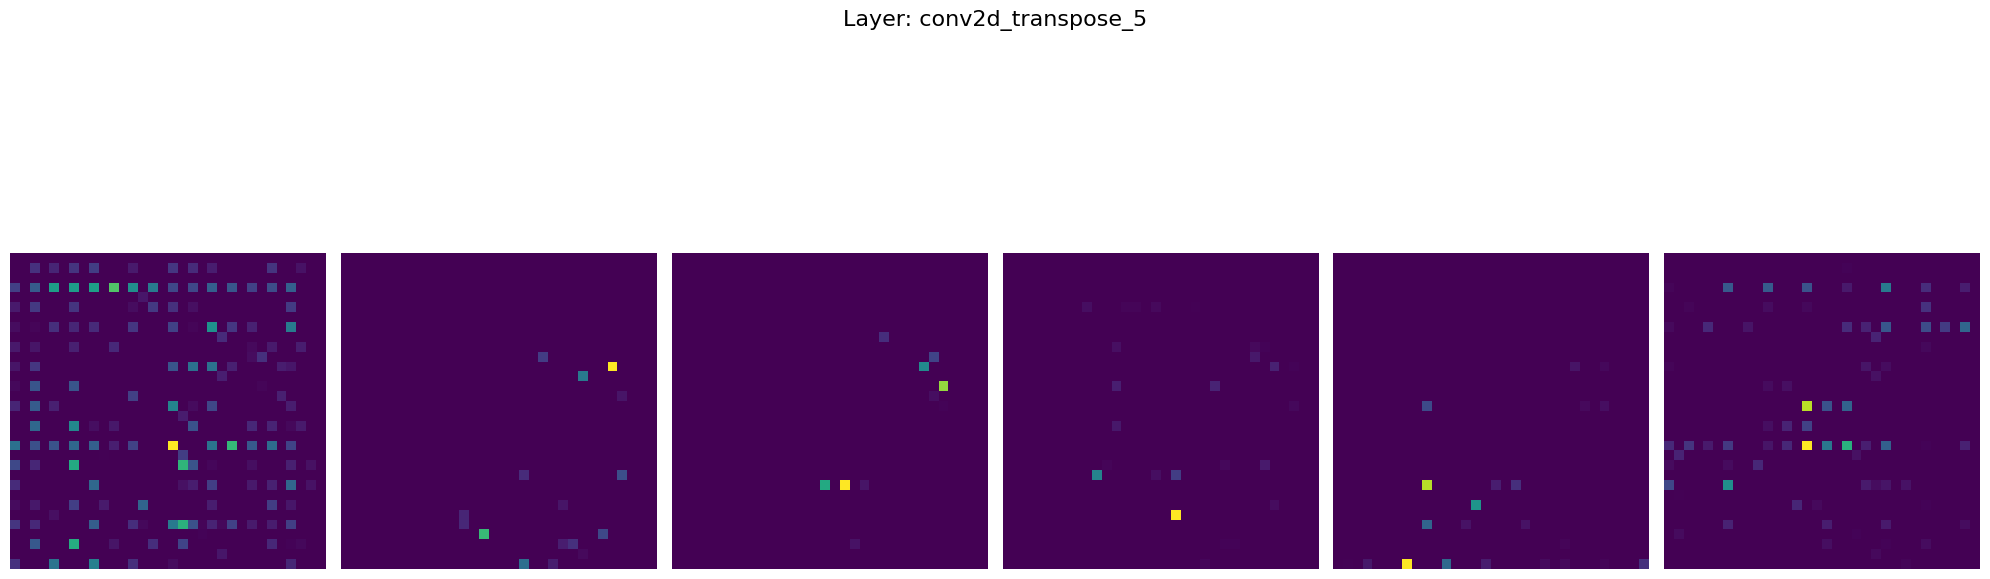

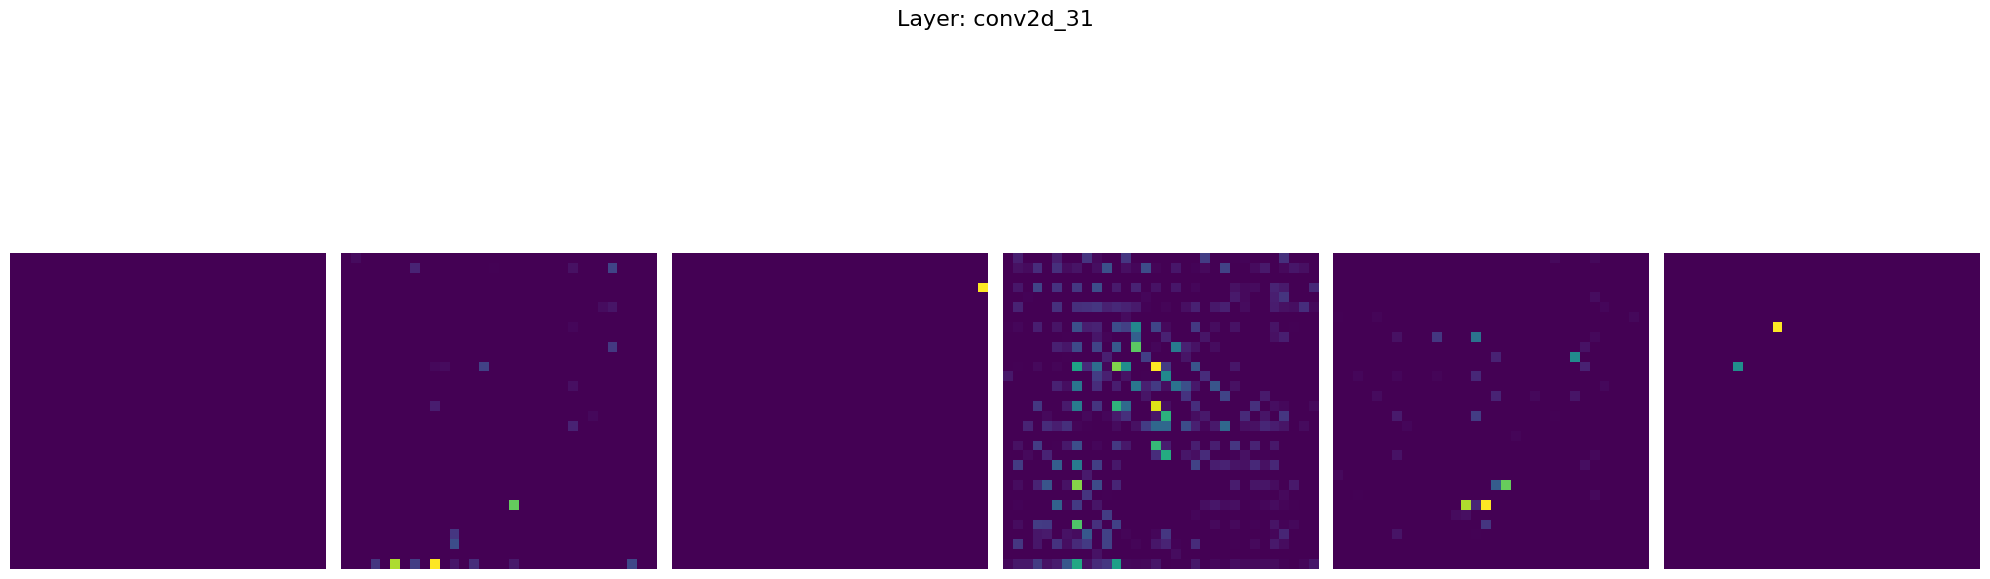

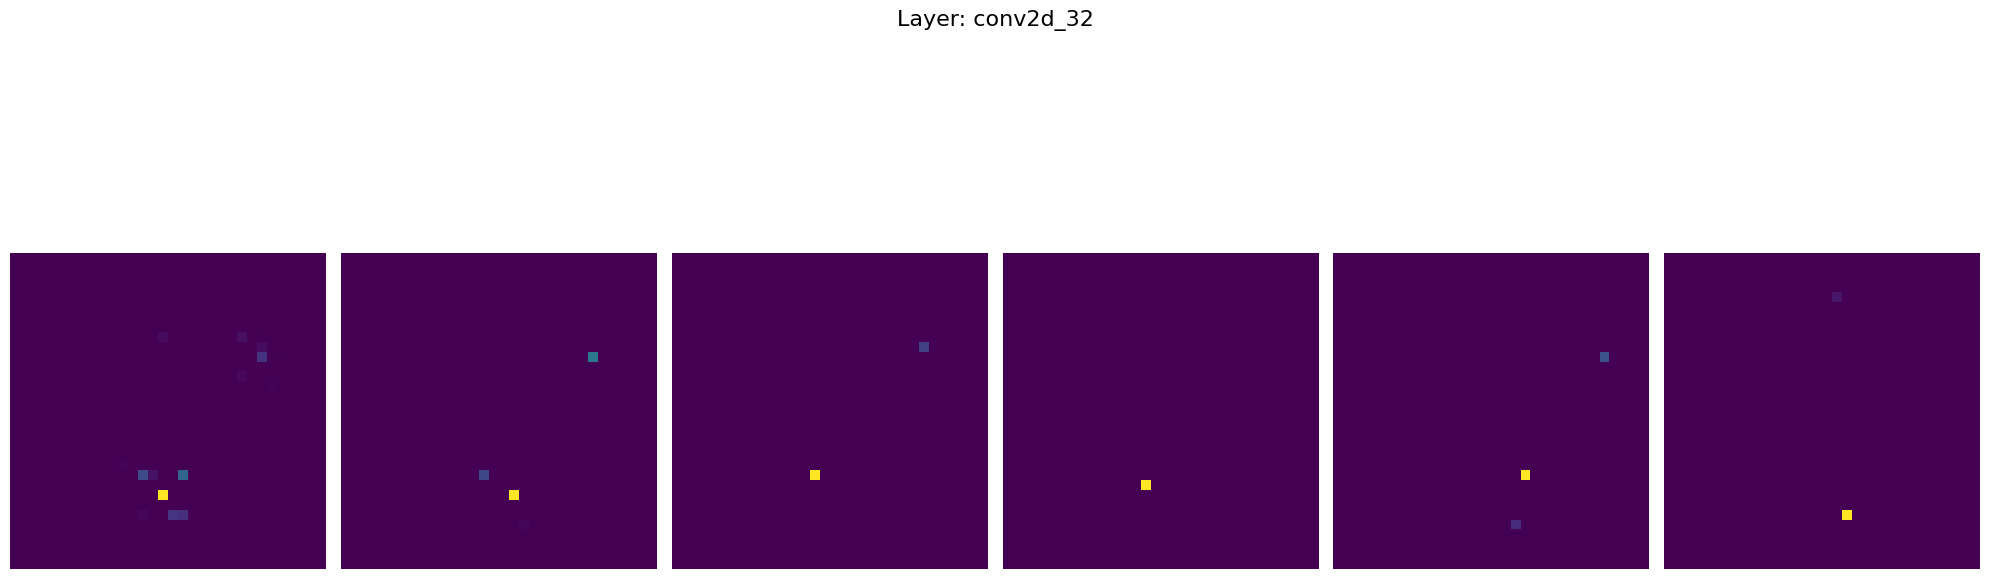

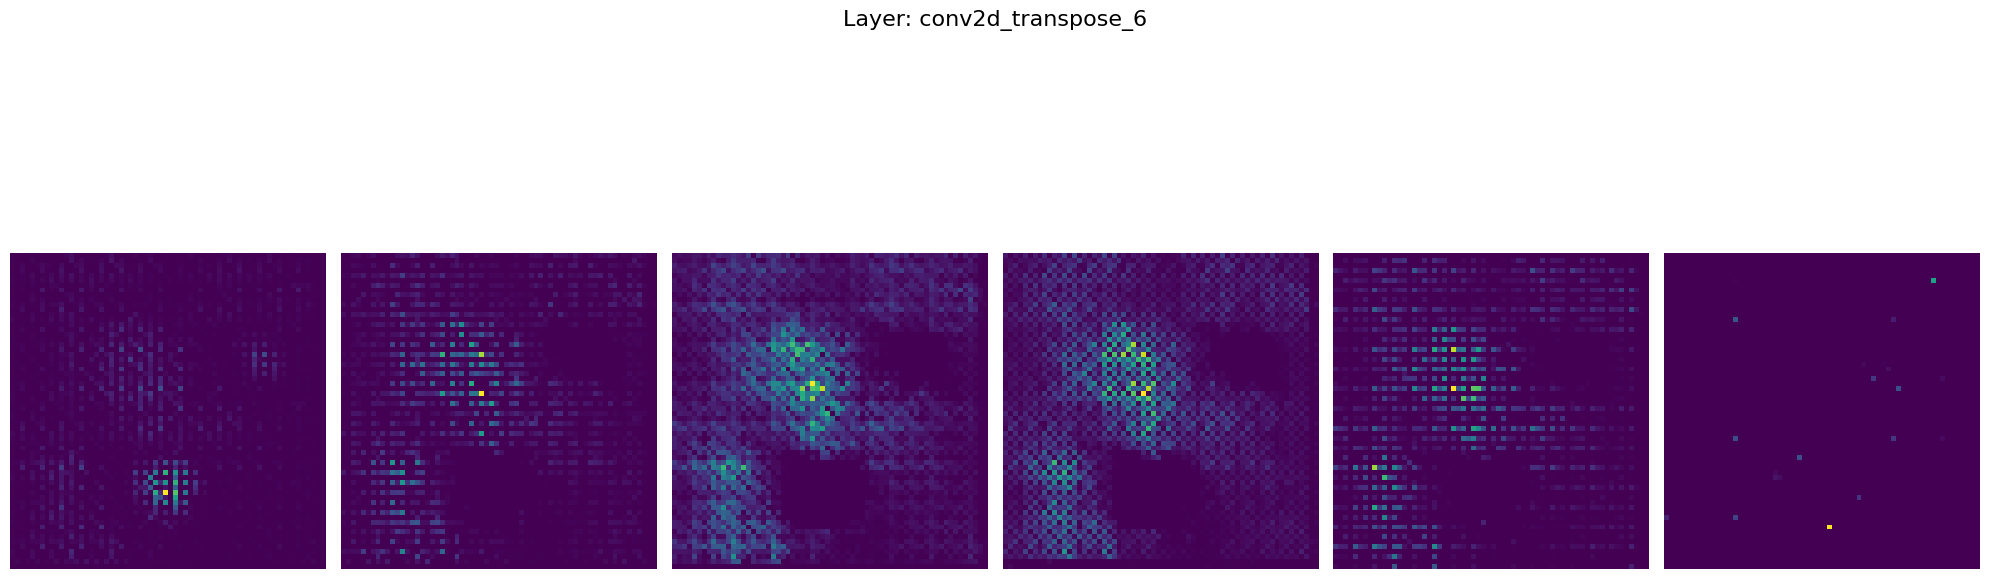

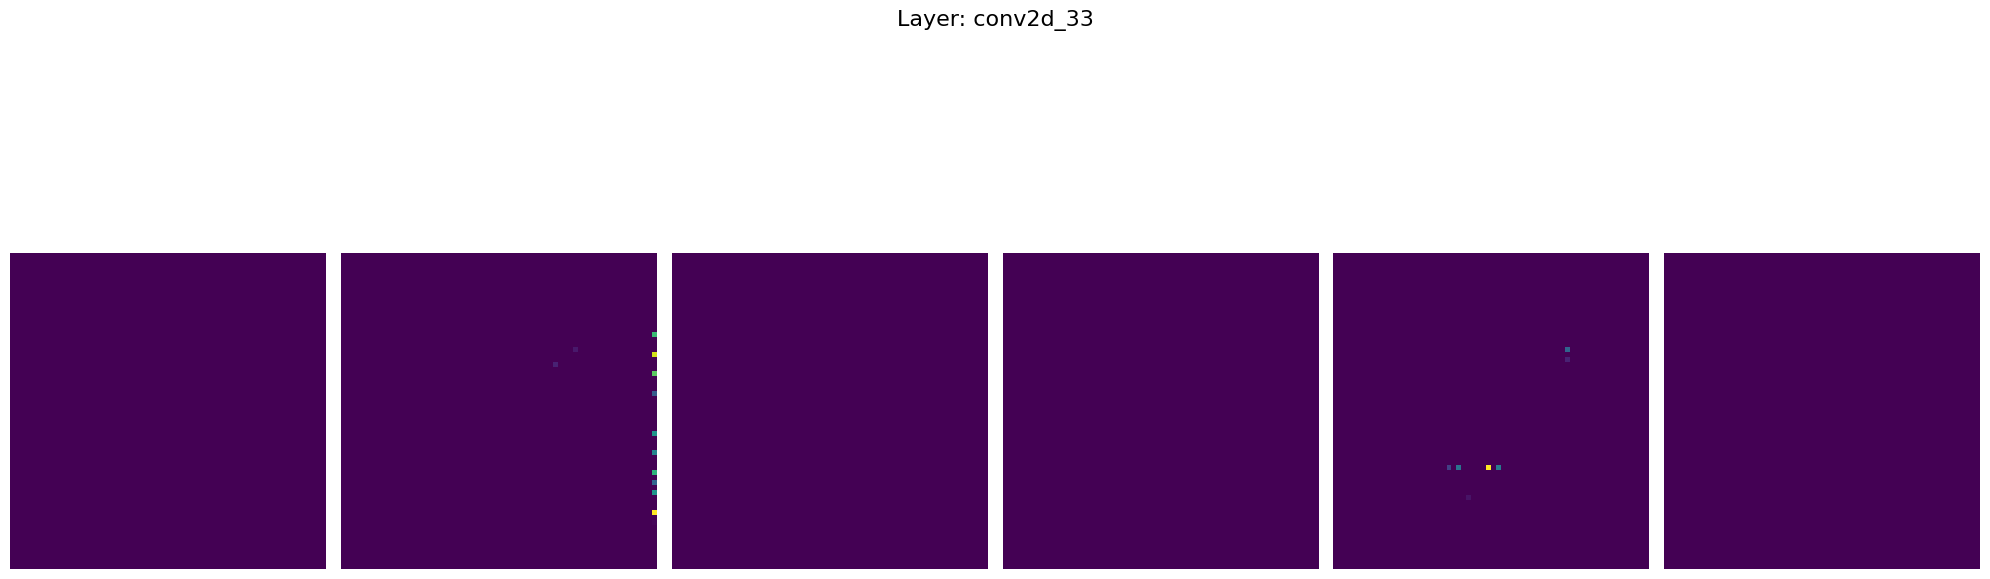

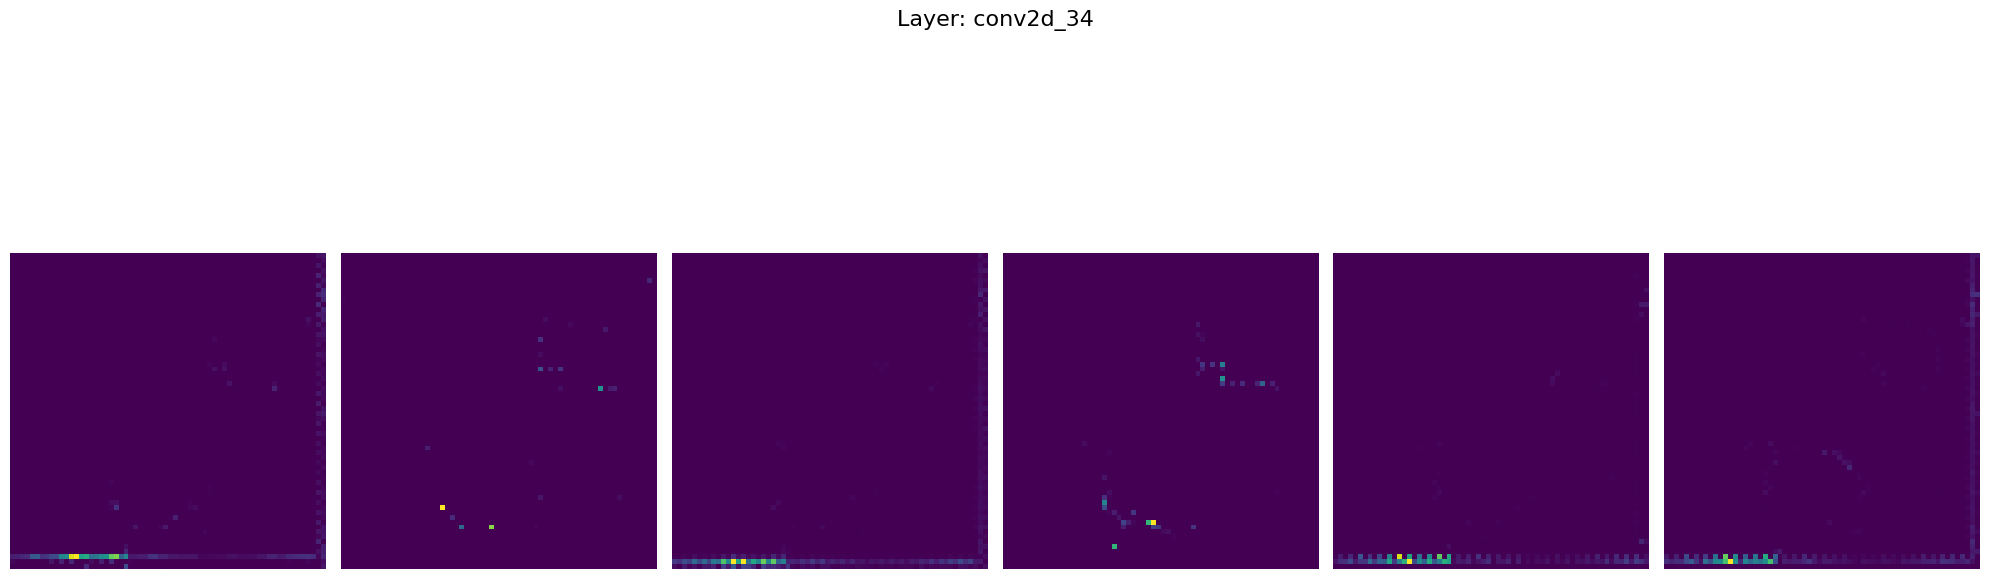

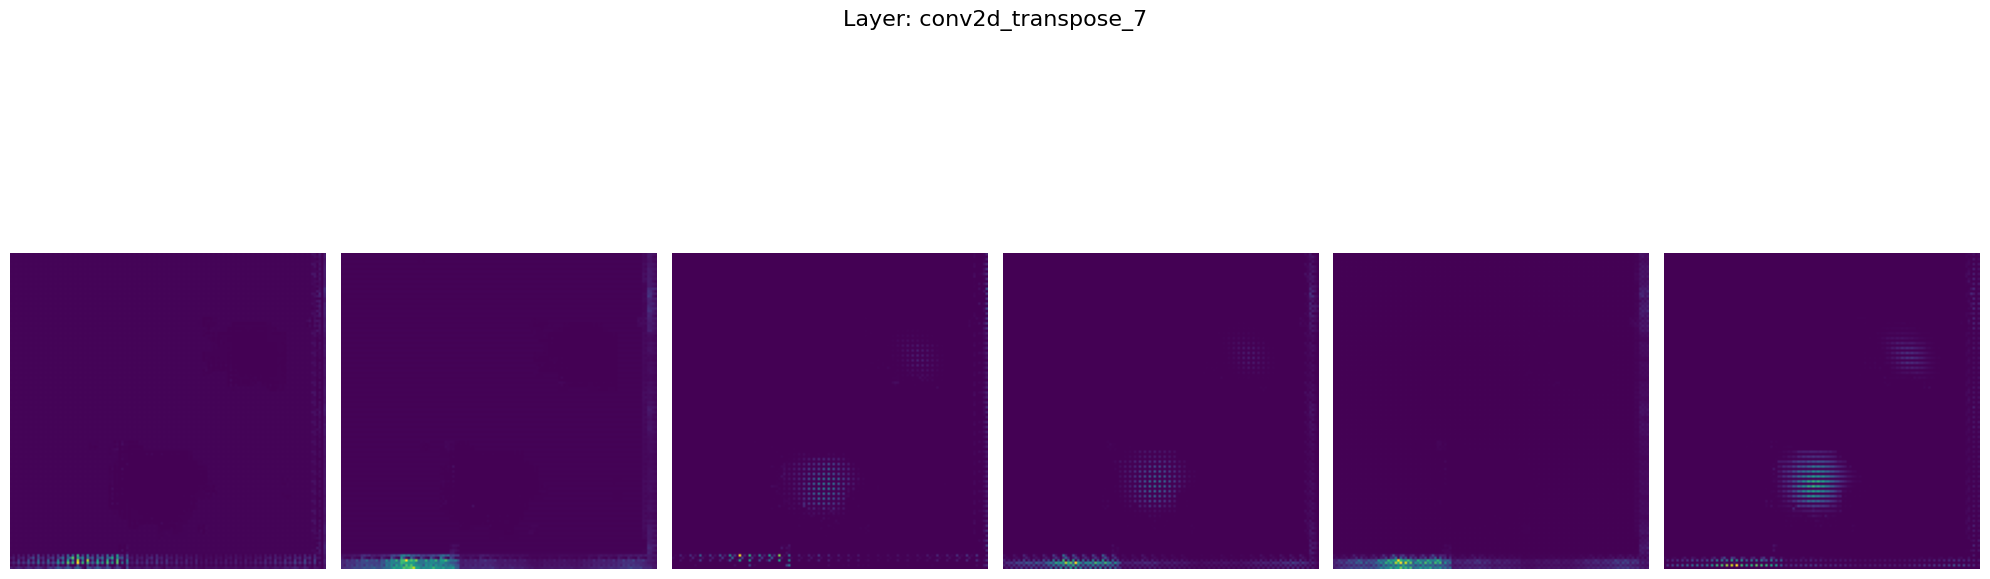

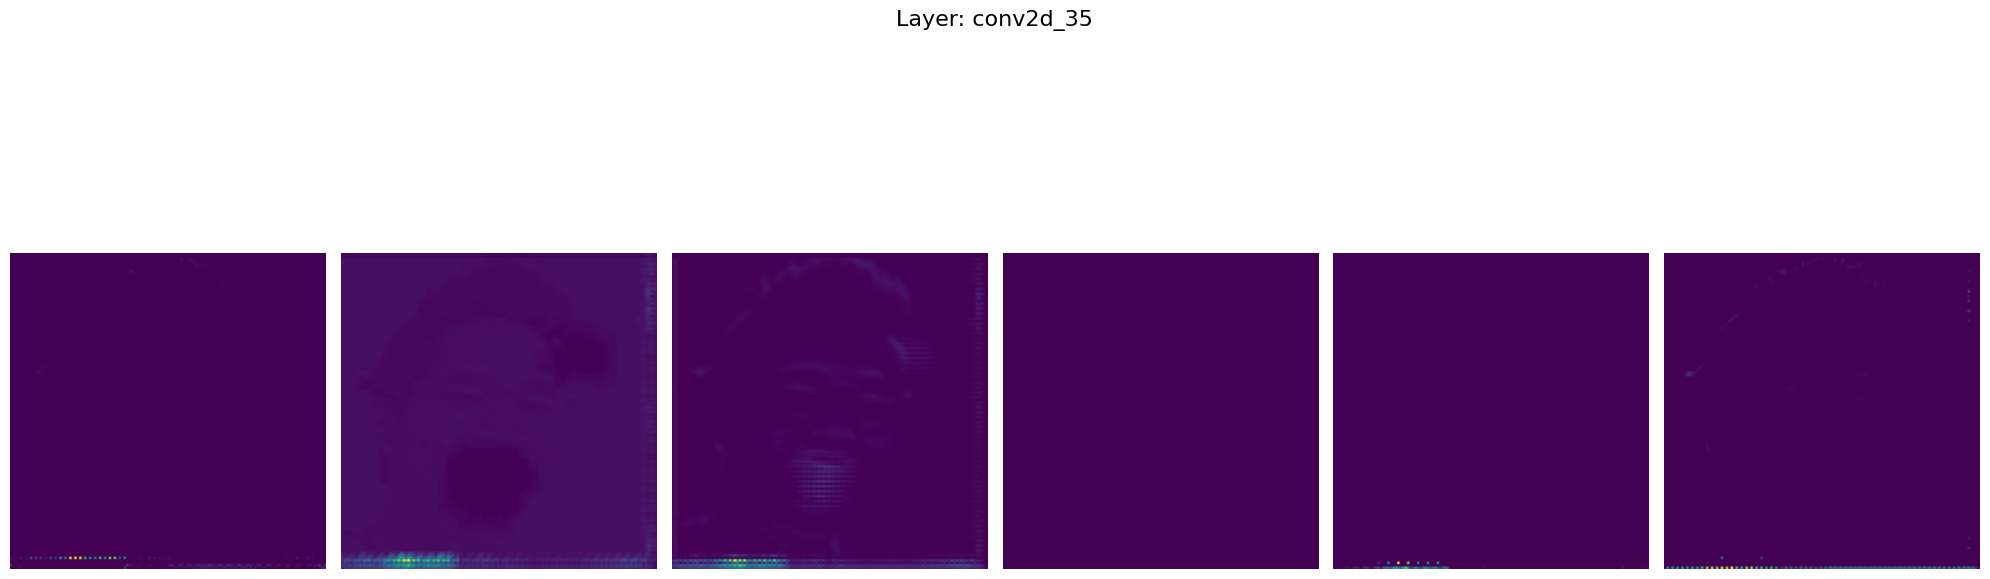

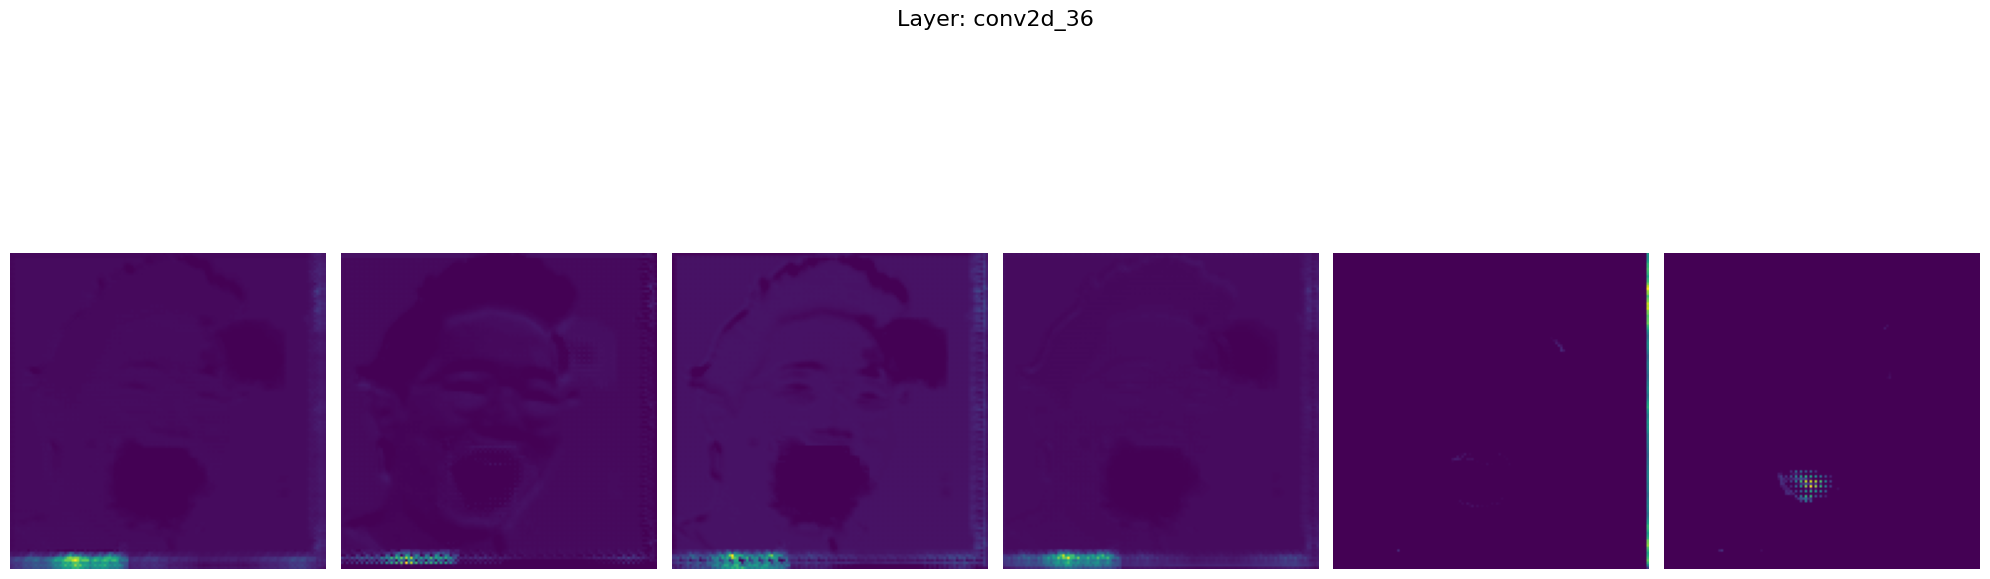

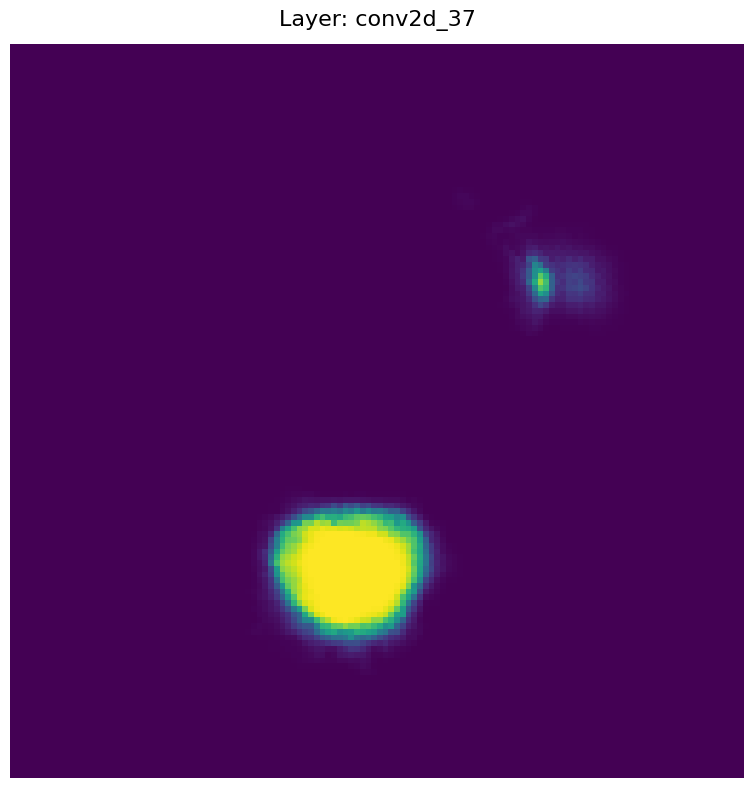

In [65]:
for layer, activation in zip(conv_layers, activations):
    plot_feature_maps(activation, layer.name)

In [66]:
unet.evaluate(test_data)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9920 - dice_coefficient: 0.7926 - loss: 0.0220


[0.02743816003203392, 0.9912217855453491, 0.7730040550231934]

In [16]:
#Function to plot the predictions with orginal image, original mask and predicted mask
def plot_preds(idx):
    plt.figure(figsize = (15, 15))
    test_img = images_test[idx]
    test_img = tf.expand_dims(test_img, axis = 0)
    test_img = tf.expand_dims(test_img, axis = -1)
    pred = unet.predict(test_img)
    print(np.unique(pred))
    pred = pred.squeeze()
    print(np.unique(pred))
    thresh = pred > 0.5
    plt.subplot(1,3,1)
    plt.imshow(images_test[idx])
    plt.title(f'Original Image {idx}')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(masks_test[idx])
    plt.title('Actual Mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(thresh)
    plt.title('Predicted Mask')
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
[0.0000000e+00 1.2580615e-38 1.4786426e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[0.0000000e+00 1.2580615e-38 1.4786426e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
[0.0000000e+00 1.2120740e-38 1.2596846e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[0.0000000e+00 1.2120740e-38 1.2596846e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
[0.0000000e+00 1.2935578e-38 1.4357980e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[0.0000000e+00 1.2935578e-38 1.4357980e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
[1.4450658e-18 3.6546903e-18 5.8627232e-18 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[1.4450658e-18 3.6546903e-18 5.8627232e-18 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
[0.0000000e+00 1.5873084e-38 3.5828450e-38 ... 9.9991345e-01 9.9992859e-01
 9

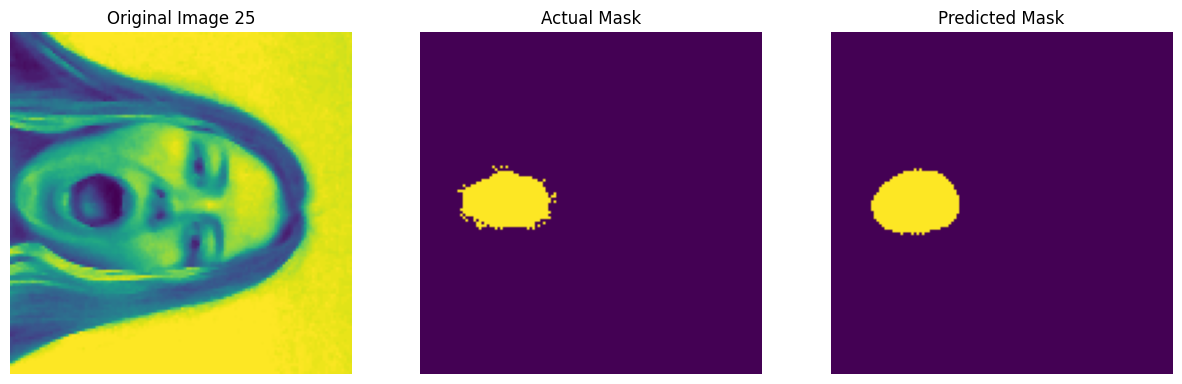

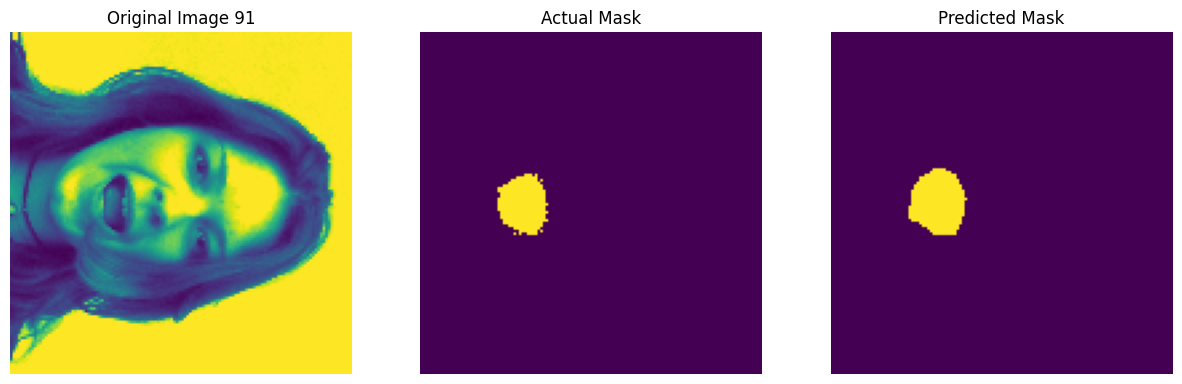

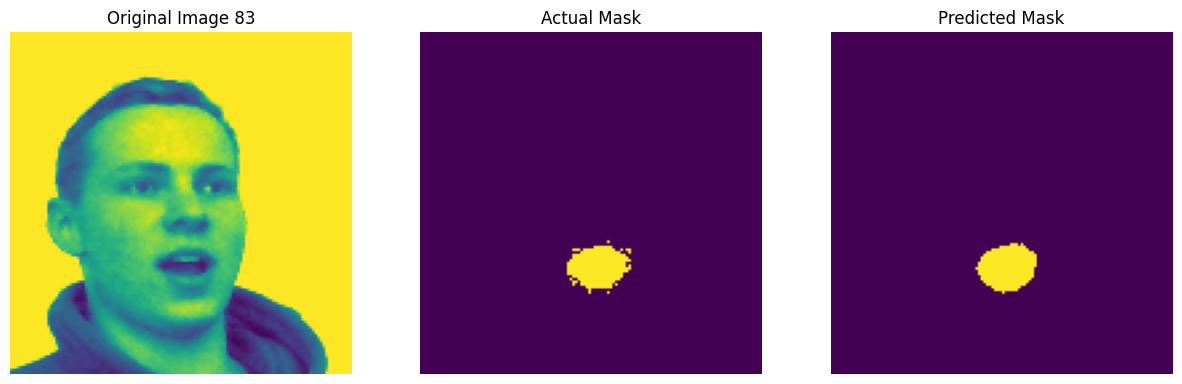

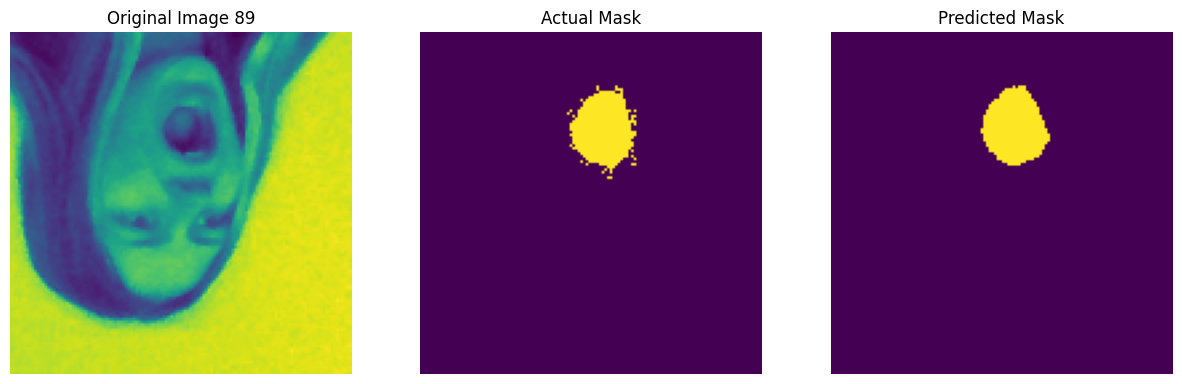

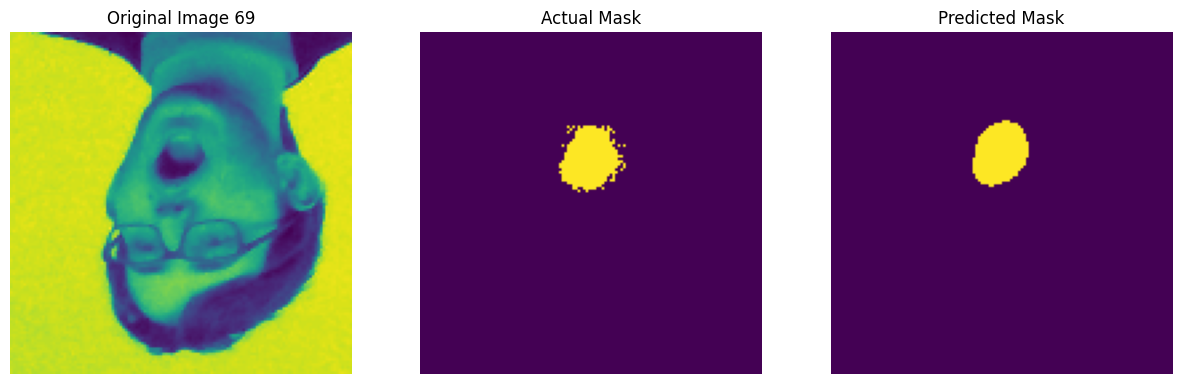

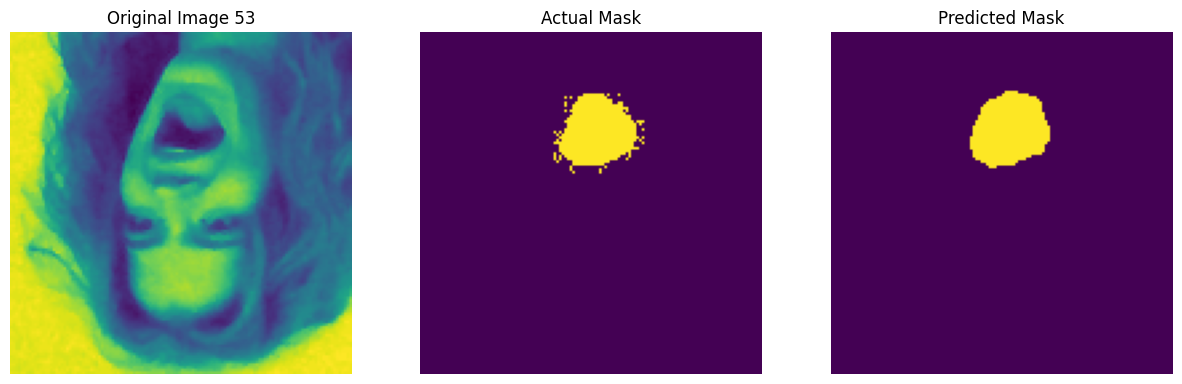

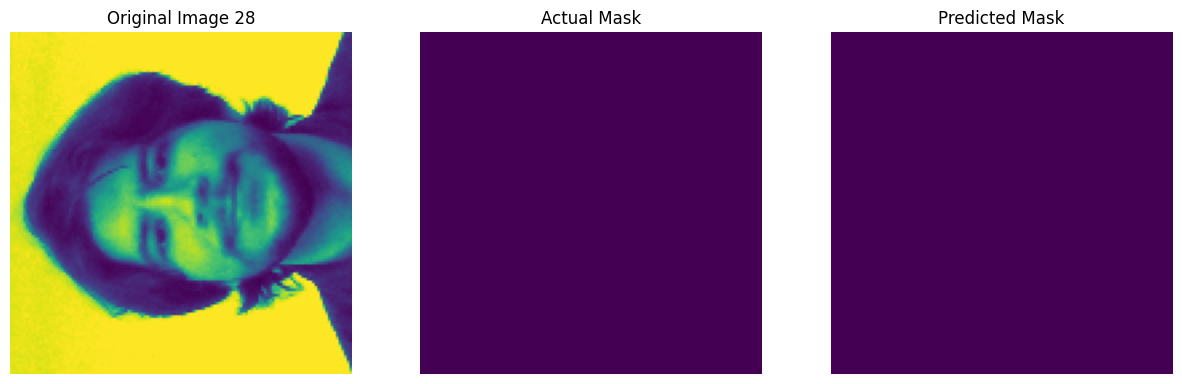

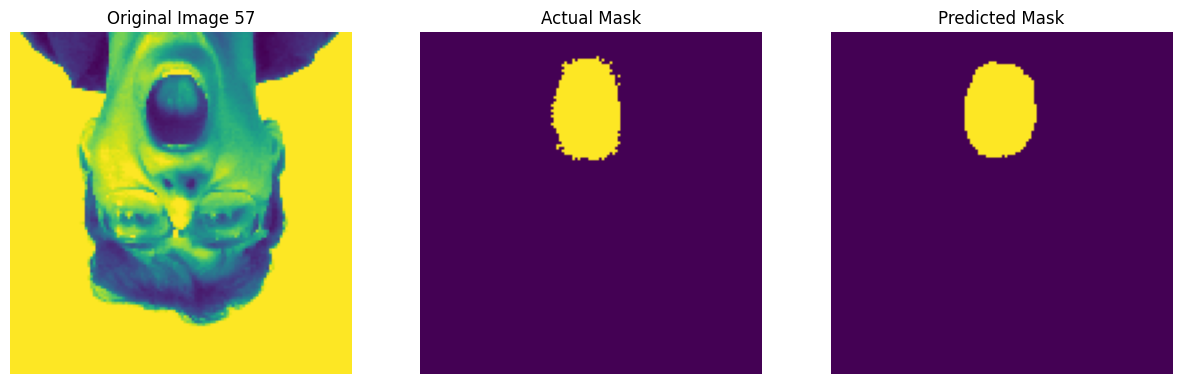

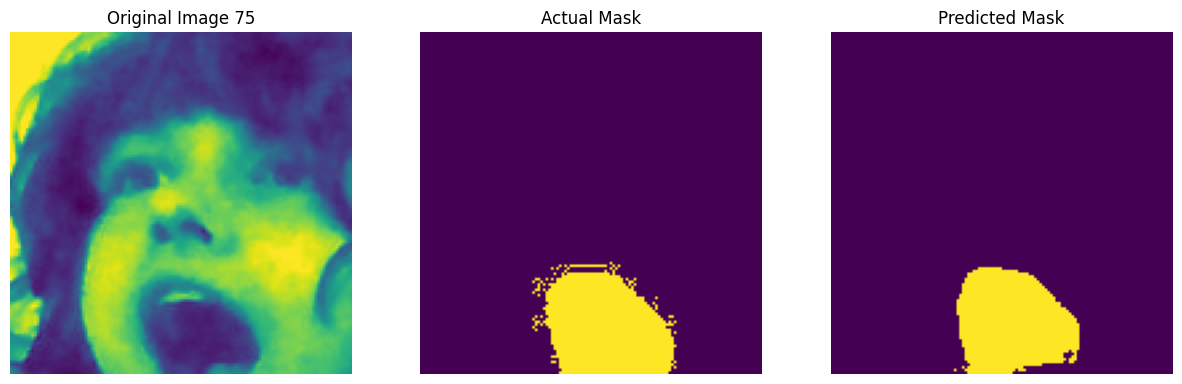

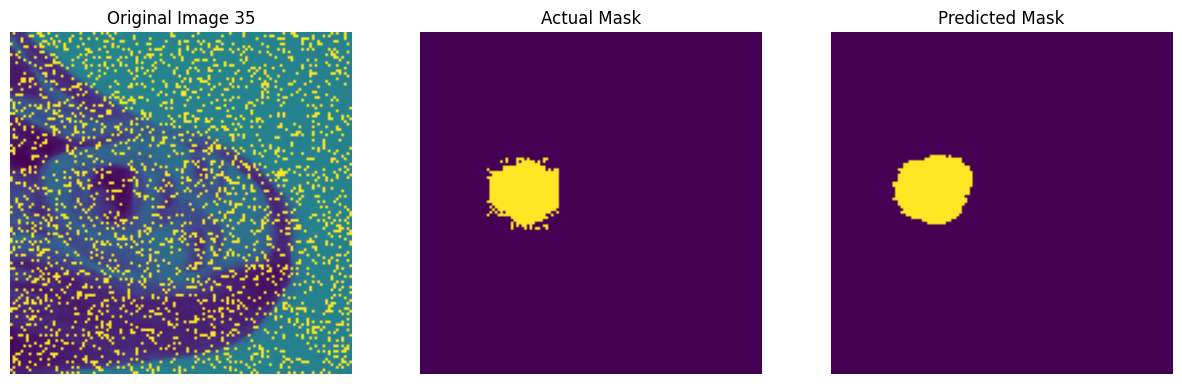

In [19]:
for i in [random.randint(0, 100) for i in range(10)]:
    plot_preds(i)

In [69]:
# #Saving the model
# unet.save('unet_model.keras')

In [17]:
unet = modelLoading("unet_model.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[0.0000000e+00 1.2721629e-38 1.6676019e-38 ... 2.2019291e-02 2.4457447e-02
 2.9178277e-02]
[0.0000000e+00 1.2721629e-38 1.6676019e-38 ... 2.2019291e-02 2.4457447e-02
 2.9178277e-02]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
[0.0000000e+00 1.5217552e-38 1.8032176e-38 ... 9.9994528e-01 9.9996114e-01
 9.9997270e-01]
[0.0000000e+00 1.5217552e-38 1.8032176e-38 ... 9.9994528e-01 9.9996114e-01
 9.9997270e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
[0.0000000e+00 1.4076297e-38 2.0778197e-38 ... 9.9999964e-01 9.9999976e-01
 9.9999988e-01]
[0.0000000e+00 1.4076297e-38 2.0778197e-38 ... 9.9999964e-01 9.9999976e-01
 9.9999988e-01]


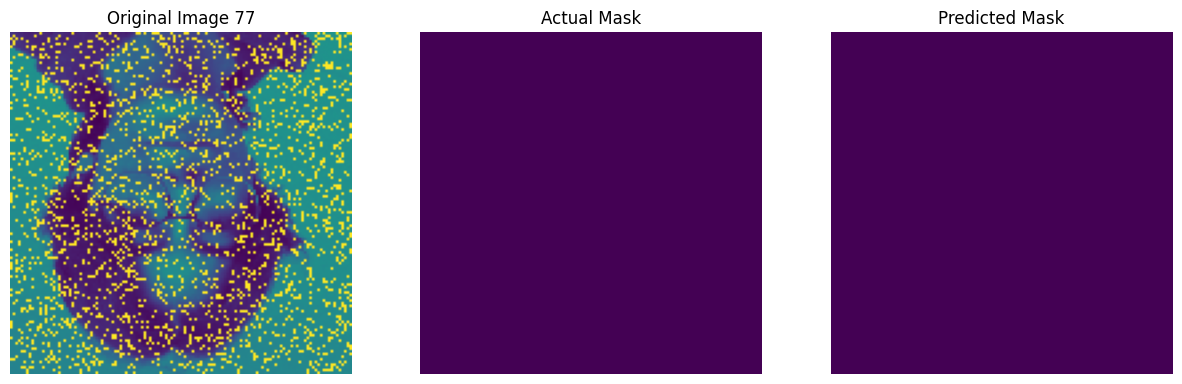

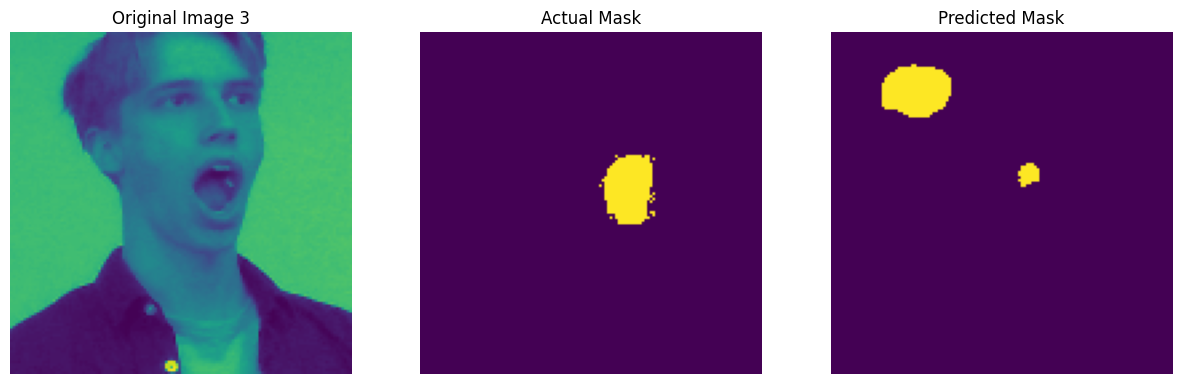

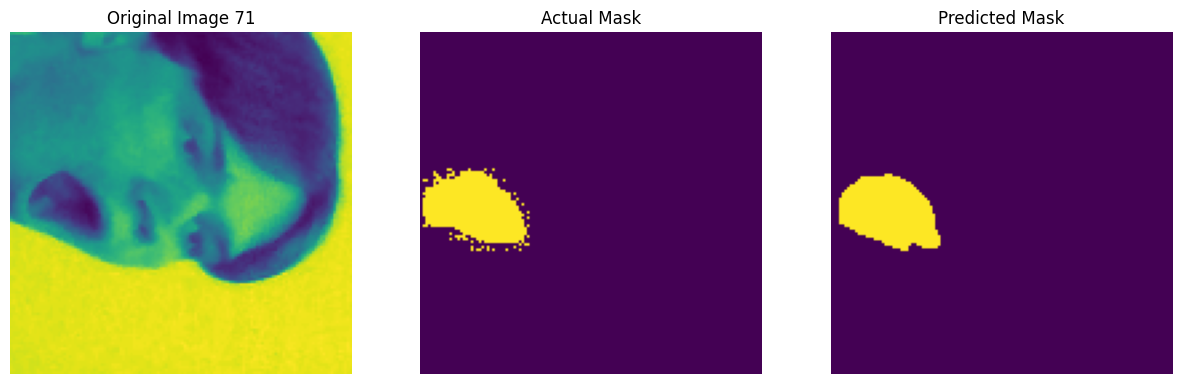

In [18]:
for i in [random.randint(0, 100) for i in range(3)]:
    plot_preds(i)